### Machine Learning Project - **Alice DEVILDER**

# Twitter Climate Change Sentiment Analysis

This project focuses on the sentiment analysis of tweets related to climate change by building and comparing machine learning models to classify whether a person believes in climate change based on novel tweet data. 
The dataset used for this analysis was collected as part of a project funded by *a Canada Foundation for Innovation JELF Grant* awarded to **Chris Bauch** at the *University of Waterloo*.  
It corresponds to the [Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset) from Kaggle .

### Some context

Climate change remains a topic of significant global concern, prompting ongoing discussions and debates on social media platforms like Twitter. With the proliferation of climate-related content online, distinguishing between different perspectives and attitudes towards climate change is crucial for understanding public sentiment and informing policy decisions.

Twitter serves as a valuable source of real-time data reflecting diverse viewpoints on climate change, ranging from support for climate action to skepticism or denial of its existence. By leveraging machine learning techniques, this project aims to analyze and classify tweet sentiments to discern whether individuals express belief or disbelief in climate change.

In this dynamic digital landscape, the ability to accurately classify tweet sentiments offers valuable insights into public perceptions and attitudes towards climate change. By building and comparing machine learning models, this project seeks to enhance our understanding of the nuanced discourse surrounding climate change on social media platforms like Twitter.

### About Dataset

The dataset aggregates tweets pertaining to climate change collected between *April 27, 2015*, and *February 21, 2018*. A total of **43,943 tweets** were annotated for sentiment analysis. Each tweet is independently labelled by three reviewers, and only tweets where all three reviewers agreed on the sentiment are included in the dataset.

Each tweet is labelled with one of the following classes:

* **2 (News):** The tweet links to factual news about climate change.
* **1 (Pro):** The tweet supports the belief of man-made climate change.
* **0 (Neutral):** The tweet neither supports nor refutes the belief of man-made climate change.
* **-1 (Anti):** The tweet does not support the belief of man-made climate change. They are climate change denier or skeptics.

Moreover, the dataset includes three columns:

**sentiment:** The sentiment label of the tweet.  
**message:** The text content of the tweet.  
**tweetid:** The unique identifier of the tweet.

### Project Objective

The project objective is to build and compare machine learning models to classify whether a person believes in climate change based on novel tweet data. By leveraging the dataset collected as part of the Canada Foundation for Innovation JELF Grant, the aim is to develop robust classification algorithms that accurately distinguish between different perspectives on climate change expressed in tweets. The project seeks to evaluate the performance of various machine learning techniques and identify the most effective model for sentiment analysis of climate change-related tweets on Twitter.

## Import librairies and dataset

In [1]:
# %pip install transformers
# %pip install gensim
# %pip install wordcloud
# %pip install xgboost

In [2]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from transformers import DistilBertTokenizerFast, DistilBertModel
import torch
from gensim.models import Word2Vec

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import warnings
import time

my_seed = 1
rng = np.random.default_rng(seed=my_seed) # random number generator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can first import the dataset and how it looks like.

In [3]:
df = pd.read_csv('twitter_sentiment_data.csv')

## 1. Data Cleansing 

Let's see how the dataset looks like using ```df.head(10)```.

In [4]:
df.head(10)

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489
6,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125430236684289
7,2,RT @CCIRiviera: Presidential Candidate #Donald...,793126558688878592
8,0,RT @AmericanIndian8: Leonardo DiCaprio's clima...,793127097854197761
9,1,#BeforeTheFlood Watch #BeforeTheFlood right he...,793127346106753028


In [5]:
negative_messages = df[df['sentiment'] == -1]['message']
random_negative_messages = negative_messages.sample(10, random_state=my_seed)
for message in random_negative_messages:
    print(message)

By saying that Global Warming is a challenge for D Coast Guard,BO was telling the cadets, $q$More coastline to guard$q$ https://t.co/RabZt5zrZy
RT @MinnDad: @FredZeppelin12 Man made global warming is not even a clever hoax. It$q$s purely big gov$q$t attempting to tax the air. Fear tacti…
RT @RealJamesWoods: Federal scientist cooked climate change books ahead of Obama presentation, whistle blower charges ///#NoSurpriseHere ht…
RT @SteveWorks4You: HOLLYWOOD RAPS $q$HYPOCRITE$q$ LEONARDO DICAPRIO$q$S $q$GLOBAL WARMING ORG FOR EMBEZZLING$q$ 1MBD BILLIONS https://t.co/s5LnYFmAN…
RT @realDonaldTrump: The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitive.
Every dollar spent $q$fighting$q$ global warming lands in someone$q$s pocket.
RT @BigJoeBastardi: Apparently human induced climate change is trying to trick you into believing its natural cause it resembles reversals…
RT @Writeintrump: If President Obama wants to get people excit

When reading some tweets with **Anti** sentiment, we can confirm that these tweets deny the belief of climate change (eg. *"The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitive."*).

Then we can also have some information about the dataset by calling ```df.info```, such as ncol, nrow, nbr missing values, dtypes.

In [6]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


This dataset has **43943** entries and **3** columns: **sentiment**, **message** and **tweetid**.

Let's see now if there are some nan values and duplicates. 

In [7]:
pd.isnull(df).sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [8]:
print("There are", df.duplicated(['message', 'sentiment']).sum(), "duplicates in the dataset. So we will remove them. \n")

df = df.drop_duplicates(['message','sentiment'], inplace=False).reset_index(drop=True)
print("Duplicates removed. Now, the dataset has", df.shape[0], "rows. \n")

# Check if there are messages with the same content but different sentiment
print("Checking for messages with the same content but different sentiment... \n")

duplicates = df[df.duplicated(['message'], keep=False)].sort_values(by=['message'])
duplicates

There are 2902 duplicates in the dataset. So we will remove them. 

Duplicates removed. Now, the dataset has 41041 rows. 

Checking for messages with the same content but different sentiment... 



,sentiment,message,tweetid
42,2,RT @ABCPolitics: .@realDonaldTrump vows to can...,793151228498866176
125,1,RT @ABCPolitics: .@realDonaldTrump vows to can...,793216460524888064
4402,0,RT @AngelicaJoy__: It's so nice out LOL global...,800125205653897216
4938,1,RT @AngelicaJoy__: It's so nice out LOL global...,802590953777364992
3046,0,"RT @AssaadRazzouk: In the new new world, China...",797651999395368960
3081,1,"RT @AssaadRazzouk: In the new new world, China...",797706914226376704
97,0,RT @COP22: In 4 days the most ambitious climat...,793197191443603456
222,1,RT @COP22: In 4 days the most ambitious climat...,793308788627570688
1452,2,RT @Channel4News: .@LeoDiCaprio calls on citiz...,795560731609546752
1480,1,RT @Channel4News: .@LeoDiCaprio calls on citiz...,795619506844336128


As they don't have the sentiment, if we drop these duplicates, we will loose some information about the sentiment. Therefore we will keep them.

The dataset is clean! There is no null value and no duplicate. We can now move on to the preprocessing part. 

### Some analysis of the dataset

In [9]:
df.sample(10, random_state=my_seed)

,sentiment,message,tweetid
7243,1,"RT @RockedReviews: No, I'm definitely worried ...",812993977163071488
1850,2,Incoming GOP assemblyman believes climate chan...,796382576625627136
24591,1,Tell Congress: Condemn climate denial. Admit c...,912629689633648640
34775,2,Kenya’s Climate Change Bill Aims to Promote Lo...,625719400553820160
24743,2,Flights worldwide will encounter more turbulen...,915622120088104962
40634,1,Understanding and action are two different iss...,783408234971496448
30868,1,As I said according to an international group ...,954345646252855297
27958,2,Extreme weather strikes as global warming wrea...,955417310075920385
8748,1,"2 hours in, climate change gone.... #Inaugurat...",822653702783856642
26369,1,RT @ClimateAdam: You may think: 'we don't know...,941506991066894337


Looking at a sample of 10 rows of the data we can observe and make the following assumptions:

* Some tweets contain twitter handles (e.g @IEA), numbers (e.g year 1995), hashtags (e.g #BeforeTheFlood) and re-tweets (RT).
* Some tweets contain names of ogarnisations, continents and countries.
* New lines are represented by '\n' in the tweet string.
* The tweets may contain URLs.
* The tweets may contain percetages, money symbols and emoticons.

Let's check that.

In [10]:
print("Number of @ contained in the tweets:", df['message'].str.contains('@').sum())
print("Number of # contained in the tweets:", df['message'].str.contains('#').sum(), "\n")

print("Number of url contained in the tweets:", df['message'].str.contains('http').sum(),"and number of www contained:", df['message'].str.contains('www').sum())
print("Number of new lines contained in the tweets:", df['message'].str.contains('\n').sum())
print("Number of re-tweets (RT) contained in the tweets:", df['message'].str.contains('RT').sum(), "\n")

# Check if there are emojis in the tweets
def find_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

emojis = df['message'].apply(find_emojis)
emojis = [e for e in emojis if e != []]
print("There are", len(emojis),"emojis in the tweets such as:", emojis[:10])


Number of @ contained in the tweets: 28300
Number of # contained in the tweets: 7931 

Number of url contained in the tweets: 24665 and number of www contained: 13
Number of new lines contained in the tweets: 3794
Number of re-tweets (RT) contained in the tweets: 22348 

There are 1088 emojis in the tweets such as: [['👀', '👍🏼'], ['👇👇'], ['✔︎', '✔︎', '✔︎', '✔︎'], ['☄', '⛱'], ['😳'], ['🌍', '💀'], ['🖐'], ['😮'], ['😳'], ['👏🏽', '👏🏽', '👏🏽']]


### Before doing some preprocessing, let's see the **Distribution Of The Target Variable**

In [11]:
# Create class distribution dataframe
class_distribution = pd.DataFrame(list(df['sentiment'].value_counts()), index = ['Pro', 'News', 'Neutral', 'Anti'], columns = ['Count'])
class_distribution.head()
    

,Count
Pro,20605
News,9073
Neutral,7505
Anti,3858


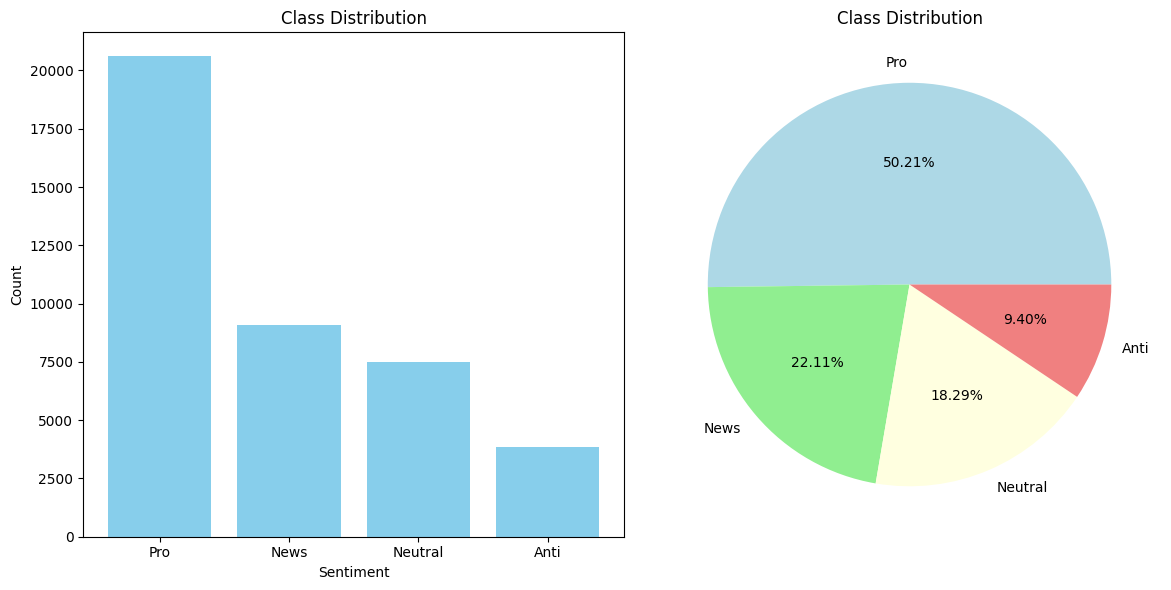

In [12]:
# Plot class distribution
plt.figure(figsize=(12, 6))

# Create left subplot for bar plot
plt.subplot(1, 2, 1)
plt.bar(class_distribution.index, class_distribution['Count'], color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Create right subplot for pie plot
plt.subplot(1, 2, 2)
plt.pie(class_distribution['Count'], labels=class_distribution.index, autopct='%1.2f%%', colors=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral'])
plt.title('Class Distribution')

plt.tight_layout()
plt.show()

We can clearly notice that positive sentiment tweets dominate this dataset. Indeed, half of the tweeter messages are classified as **Pro** which means that half of the tweets supports the belief of man-made climate change. That's a relief to see that! Then, the **Anti** sentiment is really under represented with only 10% of the dataset. **Neutral** and **News** sentiments are also less represented than **Pro** but still represent 18% and 22% of the dataset respectively. 

This distribution illustrates an important bias towards the **Pro** sentiment. Therefore, the dataset might necessitate rebalancing for machine learning tasks to prevent models from developing a bias towards the majority class, which could result in poorer performance on the minority classes. Hence, we will ajust the class weights in the learning algorithm to mitigate this imbalance.

### Extrat the **Handles** to see their impact on the sentiment analysis
A Twitter handle is the username that appears at the end of your unique Twitter URL. Twitter handles appear after the @ sign in your profile URL and it must be unique to your account. A Twitter name, on the other hand, is simply there to help people find the company they're looking for.

In [13]:
def extract_handles(x):
    handles = []
    for i in x:
        h = re.findall(r'@(\w+)', i)
        handles.append(h)

    handles = sum(handles, [])
    frequency = nltk.FreqDist(handles)
    
    handle_df = pd.DataFrame({'handle': list(frequency.keys()), 'count': list(frequency.values())})
    handle_df = handle_df.nlargest(15, columns="count")

    return handle_df

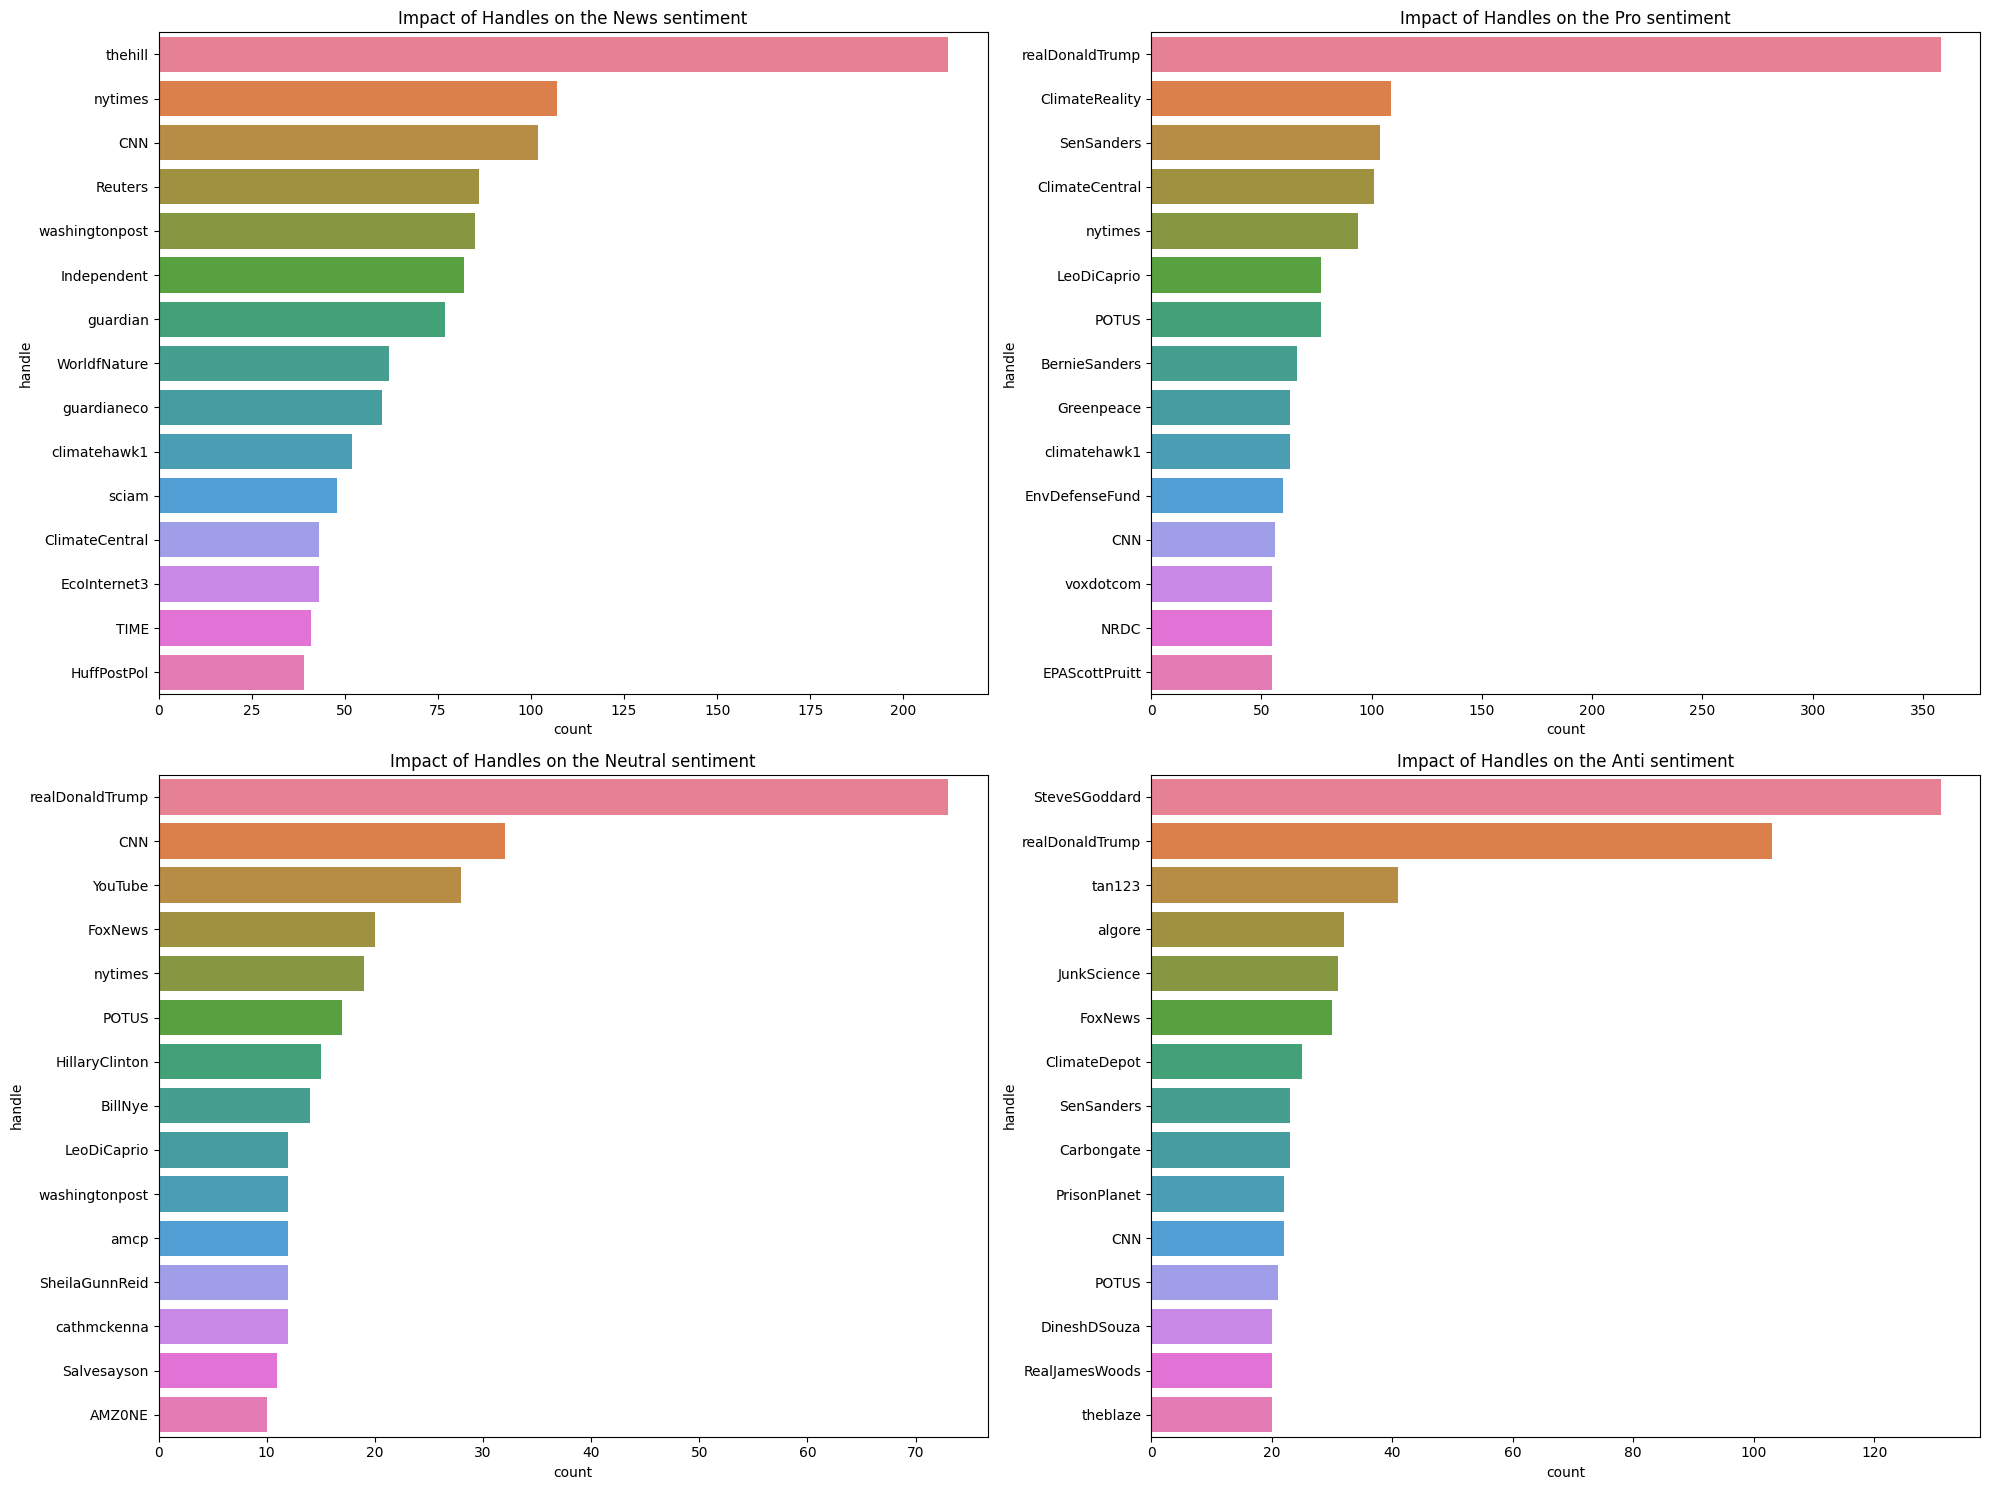

In [14]:
# Extracting handles from tweets
news_handles = extract_handles(df['message'][df['sentiment'] == 2])

pro_handles = extract_handles(df['message'][df['sentiment'] == 1])

neutral_handles = extract_handles(df['message'][df['sentiment'] == 0])

anti_handles = extract_handles(df['message'][df['sentiment'] == -1])

# Visualising the Handles
full_title = ['Impact of Handles on the News sentiment',
              'Impact of Handles on the Pro sentiment',
              'Impact of Handles on the Neutral sentiment',
              'Impact of Handles on the Anti sentiment']


# Barplot of the handles for each category
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
for i, j in enumerate([news_handles, pro_handles, neutral_handles, anti_handles]):
    row = i // 2
    col = i % 2
    sns.barplot(x='count', y='handle', data=j, ax=axes[row, col], palette='husl', hue='handle', legend=False)
    axes[row, col].set_title(full_title[i])
    
plt.tight_layout()
plt.show()

#### **Comments:**

* The top handles for **News** sentiment which is associated with sharing factual news about climate change include prominent news organizations like ***"thehill"***, ***"nytimes"***, and ***"CNN"***. These are sources that report on climate change events or studies.

* The **Pro** sentiment chart features handles that actively express support for the belief in climate change. The presence of ***"realDonaldTrump"*** as the most frequent handle is intriguing, given that public perception might not necessarily associate this handle with pro-climate change sentiment. However, the context of the tweets is not provided, so this could be due to tweets discussing the handle rather than tweets from the handle itself.  
Environmental organizations and notable public figures such as ***"ClimateReality"***, ***"SenSanders"***, and ***"LeoDiCaprio"*** also feature prominently, reflecting their advocacy for climate action. Indeed, in 2016, a documentary called *"Before The Flood"* where actor Leonardo DiCaprio meets with scientists, activists and world leaders to discuss the dangers of climate change and possible solutions was released and it was really trendy at the moment the tweets were collected.

* **Neutral** sentiment tweets include a range of handles from various domains, indicating a broad discourse that doesn't take a definitive stance on climate change. ***"realDonaldTrump"*** appears again, which might suggest the handle's tweets or tweets about it do not always convey a clear sentiment, or it may reflect the platform's central role in discussions around climate change, regardless of stance.

* Lastly, the **Anti** sentiment chart shows handles associated with climate change denial or skepticism, with ***"SteveSGoddard"*** and ***"realDonaldTrump"*** being the most prominent. Tom Nelson (***"tan123"***) is also a vocal climage change denier who thinks that *"Catastrophic anthropogenic global warming is the most massive scientific fraud in human history."*. This suggests that skepticism or denial of man-made climate change is represented in this dataset, with certain users being particularly vocal. 

### Extrat **Hashtags** to see their impact on the sentiment analysis

People use the hashtag symbol (#) before a relevant keyword or phrase in their Tweet to categorize those Tweets and help them show more easily in Twitter search. Clicking or tapping on a hashtagged word in any message shows you other Tweets that include that hashtag. Hashtags can be included anywhere in a Tweet.

In [15]:
def extract_hashtags(x):
    hashtags = []
    for i in x:
        h = re.findall(r'#(\w+)', i)
        hashtags.append(h)

    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()), 'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

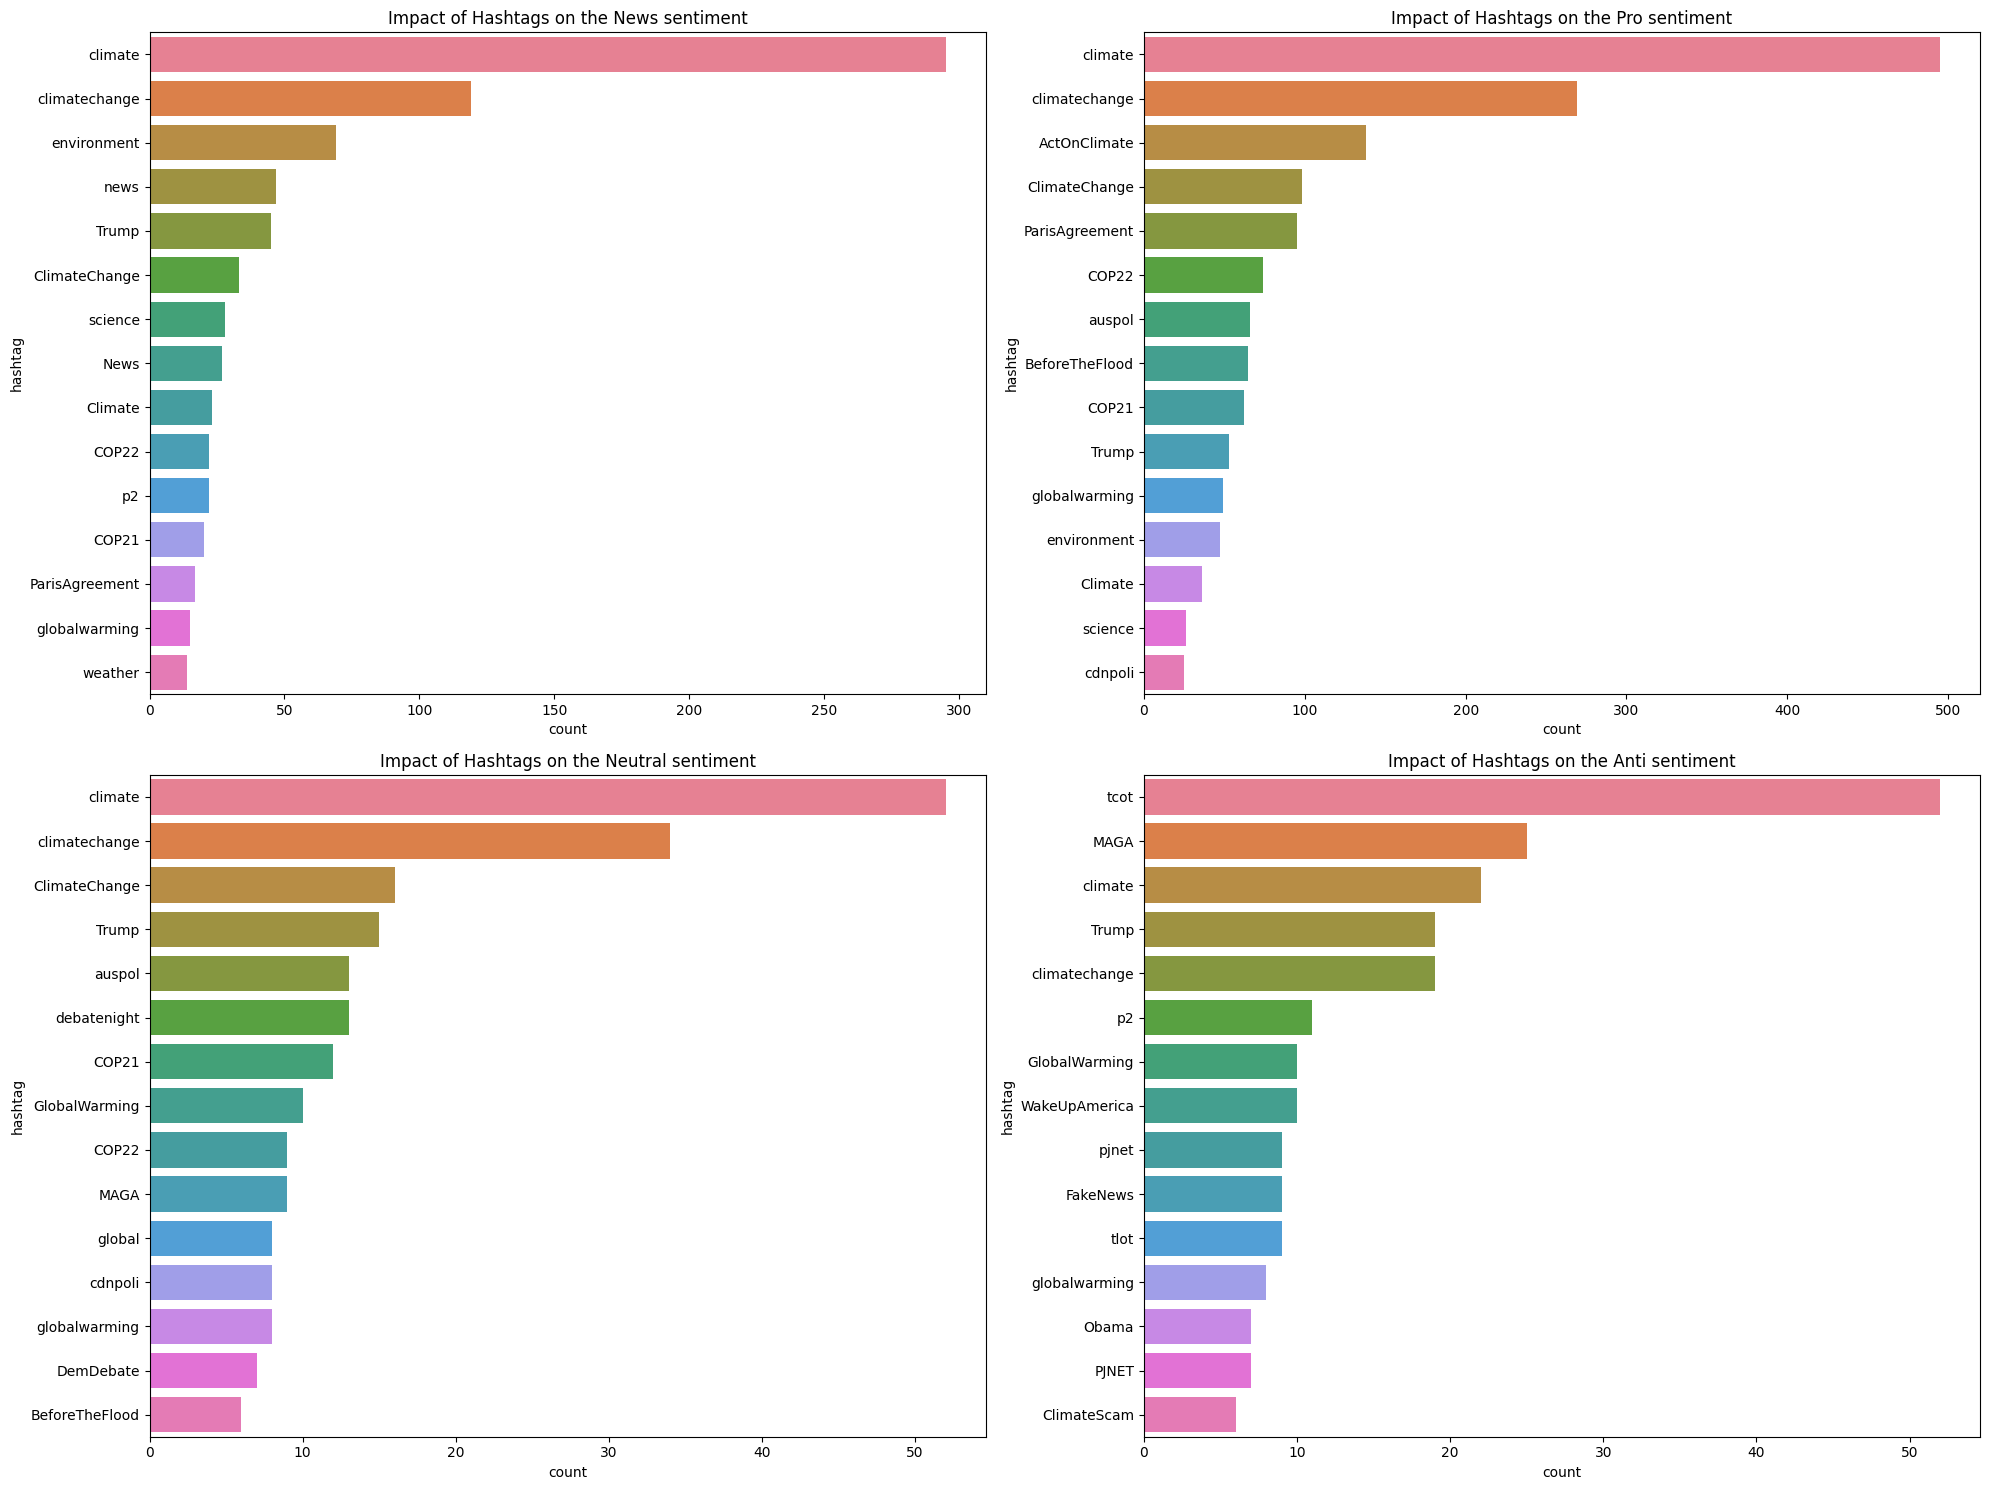

In [16]:
# Extracting hashtags from tweets
news_hashtags = extract_hashtags(df['message'][df['sentiment'] == 2])

pro_hashtags = extract_hashtags(df['message'][df['sentiment'] == 1])

neutral_hashtags = extract_hashtags(df['message'][df['sentiment'] == 0])

anti_hashtags = extract_hashtags(df['message'][df['sentiment'] == -1])

# Visualising the hashtags
full_title = ['Impact of Hashtags on the News sentiment',
              'Impact of Hashtags on the Pro sentiment',
              'Impact of Hashtags on the Neutral sentiment',
              'Impact of Hashtags on the Anti sentiment']


# Barplot of the hashtags for each category
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
for i, j in enumerate([news_hashtags, pro_hashtags, neutral_hashtags, anti_hashtags]):
    row = i // 2
    col = i % 2
    sns.barplot(x='count', y='hashtag', data=j, ax=axes[row, col], palette='husl', hue='hashtag', legend=False)
    axes[row, col].set_title(full_title[i])
    
plt.tight_layout()
plt.show()

#### **Comments:**

* The chart about **News** sentiment likely reflects the hashtags used in tweets that link to factual news about climate change.   
The most frequent hashtags include **#climate**, **#climatechange**, **#environment** and naturally **#news**, indicating these are common topics in news-related tweets. The inclusion of **#Trump** suggests that many news-related tweets might be related to political discourse or actions taken by or associated with the figure of Donald Trump during the given period. We can also notice that **#ParisAgreement**, **#COP22** are popular hashtags. Trump made headlines when he pulled out of the climate agreement, so it makes sense that these hashtags would be trending in climate change news.

* The **Pro** sentiment chart showcases the hashtags in tweets that support the belief in climate change. **#climate** and **#climatechange** is prominent, along with **#ActOnClimate**, **#ClimateChange**, and **#ParisAgreement**, reflecting advocacy and support for climate action and international efforts to combat climate change (eg. **#COP22**, **#COP21**). We can notice that **#BeforeTheFlood**, the documentary with Leonardo DiCaprio mentionned above, is also in the top hashtags.

* For the **Neutral** sentiment, hashtags like **#climate**, **#climatechange**, and **#Trump** appear again, indicating a broad conversation that encompasses various viewpoints and discussions that neither strongly support nor deny climate change. The presence of diverse hashtags suggests a range of discussions that might focus on reporting or discussing climate change without a clear advocacy or denial stance.

* In the **Anti** sentiment chart, **#tcot** (top conservatives on Twitter), **#MAGA** (Make America Great Again), and **#climate** appear most frequently. The MAGA handle and hashtag became, and remain, symbols of support for Trump. From this information we can infer that most anti climate change tweets come from Trump suporters. The presence of politically charged hashtags alongside **#climate** and **#climatechange** could indicate a political context in which climate change is discussed, often by conservative groups or individuals who are skeptical of the mainstream climate change narrative. **#FakeNews**, **#WakeUpAmerica** and **#ClimateScam** are pretty popular hashtags too. People who are anti climate change could be tweeting and retweeting information and opinions they disagree with followed by the hashtags **#FakeNews** and **#ClimateScam**' in an attempt to discredit both the information and the source.

## 2. Preprocessing

### a) Cleaning the tweet messages

Once we've done some EDA on the data, let's clean the tweet messages by removing the unnecessary entities such as *URL's*, *punctuations*, *mentions*, *numbers* and *new lines*. To this end, we will first convert all the letters to lowercase in order to normalize the data, then we remove entities that we don't need. We are going to remove them through [__Regular Expressions (RegEx)__](https://en.wikipedia.org/wiki/Regular_expression). This process uses __meta characters__ to express how to match patterns in text.

The symbol ```\w``` means "any word character" (a, ..., z) and (0, ..., 9). 
```\s``` means a white space. The brackets indicate that we take a set of character.     
```[^ ]``` matches a single character that is not contained within the brackets.   
```*``` indicates zero or more occurrences of the preceding element.   
```+``` matches the preceding element one or more times. For example, ```ab+c``` matches "abc", "abbc", "abbbc", and so on, but not "ac".   
```$``` means the ending position of the string or the position just before a string-ending newline.  

In [17]:
def clean_text(text):

    text = text.lower() # Convert to lowercase
    text = re.sub(r'@\w*', '', text)  # Removing @mentions
    text = re.sub(r'#\w*', '', text)  # Removing #hashtags
    text = re.sub(r'www\.[^\s]+|https?://[^\s]+', '', text)  # Removing hyperlinks
    text = re.sub(r'\n', '', text)  # Removing new line
    text = re.sub(r'\d+', '', text)  # Removing digits
    text = re.sub(r'\W', ' ', text)  # Removing non-word characters (\W is equivalent to [^a-zA-Z0-9_])
    text = re.sub(r'\s+', ' ', text)  # Removing extra spaces
    text = re.sub(r'^\s+|\s+?$', '', text)  # Removing extra spaces at the beginning and the ending
    
    return text


In [18]:
# Create a copy of the dataframe to avoid modifying the original dataframe
tweets = df.copy()

# Apply the clean_text function to the 'message' column
tweets['clean_tweet'] = tweets['message'].apply(clean_text)

tweets.head(10)

,sentiment,message,tweetid,clean_tweet
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,climate change is an interesting hustle as it ...
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,rt watch right here as travels the world to ta...
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,fabulous leonardo s film on change is brillian...
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,rt just watched this amazing documentary by le...
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,rt pranita biswasi a lutheran from odisha give...
5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489,unamshow awache kujinga na iko global warming
6,2,RT @CCIRiviera: Presidential Candidate #Donald...,793126558688878592,rt presidential candidate is ã â å dangerousã ...
7,0,RT @AmericanIndian8: Leonardo DiCaprio's clima...,793127097854197761,rt leonardo dicaprio s climate change document...
8,1,#BeforeTheFlood Watch #BeforeTheFlood right he...,793127346106753028,watch right here as travels the world to tackl...
9,1,RT @DrDeJarnett: It's vital that the public he...,793127915269480448,rt it s vital that the public health community...


We can make a quick check to see if there are still some emojis in the clean tweets.

In [19]:
nb_emojis = 0
for i in range(10):
    nb_emojis += len(find_emojis(tweets['clean_tweet'][i]))
print("There are", nb_emojis, "emojis in the cleaned tweets.")

There are 0 emojis in the cleaned tweets.


The tweets are now clean!

### b) Tokenization

Tokenization corresponds to the process of breaking a larger object into sub-parts, or tokens. In Natural Language Processing, tokens may vary. For instance, one may perform analysis at three levels,

- Character
- Word
- Sentence

The idea is that a sentence is a set of words, and a word is a set of characters. In this sense, the character is the atom of NLP, analogous to pixels in image processing. Nonetheless, NLP usually performs analysis at the level of words. Henceforth, we will mention "tokenization" to the process of breaking chunks of texts into its individual words. We can do so with [NLTK](https://www.nltk.org/), which is an open-source __ensemble__ of libraries, datasets and tutorials written in Python, that also constitutes a single library used in natural language processing. It was originally intended for __educational purposes__.

In [20]:
# We want to keep only important words in the tweets. So we will remove stopwords.
def tweet_tokens(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    
    return filtered_text

In [21]:
# Apply the remove_stopwords function to the 'clean_tweet' column
tweets['tweet_tokens'] = tweets['clean_tweet'].apply(tweet_tokens)

tweets.head()


,sentiment,message,tweetid,clean_tweet,tweet_tokens
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,climate change is an interesting hustle as it ...,"[climate, change, interesting, hustle, global,..."
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,rt watch right here as travels the world to ta...,"[rt, watch, right, travels, world, tackle, cli..."
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,fabulous leonardo s film on change is brillian...,"[fabulous, leonardo, film, change, brilliant, ..."
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,rt just watched this amazing documentary by le...,"[rt, watched, amazing, documentary, leonardodi..."
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,rt pranita biswasi a lutheran from odisha give...,"[rt, pranita, biswasi, lutheran, odisha, gives..."


### c) Stemming and Lemmatization 

**Stemming** and **lemmatization** are techniques used in NLP to reduce words to their base or root form. The main difference between the two is that stemming simply chops off the ends of words to remove prefixes and suffixes, while lemmatization considers the context and meaning of words to convert them to their dictionary form.

- ```Stemming``` involves applying a set of rules to remove common word endings, such as "-s", "-ing", or "-ed". For example, the word "running" would be stemmed to "run". Stemming is a simpler and faster process compared to lemmatization, but it may result in the loss of the original word's meaning.

- ```Lemmatization```, on the other hand, uses more advanced techniques to determine the base form of a word based on its part of speech and context. It takes into account the morphological analysis of words and uses a dictionary or vocabulary to map words to their base form. For example, the word "running" would be lemmatized to "run".

In sentiment analysis, the goal is to determine the sentiment or emotion expressed in a text. Stemming is generally not recommended for sentiment analysis because it can lead to the loss of important information and context. Stemming may change the meaning of words and can result in incorrect sentiment classification. Lemmatization, on the other hand, preserves the original meaning of words and is more suitable for sentiment analysis tasks.

By using lemmatization, we can ensure that sentiment analysis models have access to the correct base forms of words, which helps in capturing the intended sentiment accurately.

In [22]:
def lemmatize_text(text):

    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    
    return lemmatized_text

In [23]:
# Apply the lemmatize_text function to the 'tweet_tokens' column
tweets['lemmatized_tweet_tokens'] = tweets['tweet_tokens'].apply(lemmatize_text)
tweets['lemmatized_tweet'] = [' '.join(map(str, l)) for l in tweets['lemmatized_tweet_tokens']]
tweets.head()

,sentiment,message,tweetid,clean_tweet,tweet_tokens,lemmatized_tweet_tokens,lemmatized_tweet
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,climate change is an interesting hustle as it ...,"[climate, change, interesting, hustle, global,...","[climate, change, interesting, hustle, global,...",climate change interesting hustle global warmi...
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,rt watch right here as travels the world to ta...,"[rt, watch, right, travels, world, tackle, cli...","[rt, watch, right, travel, world, tackle, clim...",rt watch right travel world tackle climate cha...
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,fabulous leonardo s film on change is brillian...,"[fabulous, leonardo, film, change, brilliant, ...","[fabulous, leonardo, film, change, brilliant, ...",fabulous leonardo film change brilliant watch via
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,rt just watched this amazing documentary by le...,"[rt, watched, amazing, documentary, leonardodi...","[rt, watched, amazing, documentary, leonardodi...",rt watched amazing documentary leonardodicapri...
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,rt pranita biswasi a lutheran from odisha give...,"[rt, pranita, biswasi, lutheran, odisha, gives...","[rt, pranita, biswasi, lutheran, odisha, give,...",rt pranita biswasi lutheran odisha give testim...


### d) Word Embedding (from tokens to vectors)

**Word embedding** is a technique used in NLP to represent words in a continuous vector space where the semantic meaning of words is encoded based on their context in a corpus of text.

`CountVectorizer()` and `DistilBertTokenizerFast` are tools commonly used in NLP, each serving different purposes and operating at different levels of sophistication. [CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) belongs to traditional bag-of-words approaches and is a simpler technique compared to [DistilBertTokenizerFast](https://huggingface.co/docs/transformers/model_doc/distilbert), which is designed for Transformer-based models like **BERT** (Bidirectional Encoder Representations from Transformers). BERT is a revolutionary deep learning model introduced by *Google* in 2018, built upon the transformer architecture. Unlike previous models, BERT is bidirectional, considering both left and right context when processing text, which enables it to capture a more comprehensive understanding of language.

`CountVectorizer()` converts a collection of text documents into a matrix of token counts, where each row represents a document and each column represents a unique token in the corpus. The values in the matrix indicate the frequency of each token in the corresponding document. However, `CountVectorizer()` does not capture the semantic meaning or context of words. It treats each word as an independent feature and does not consider word order or relationships between words.

On the other hand, `DistilBertTokenizerFast` tokenizes input text into subwords or wordpieces, which are then fed into the BERT model. Unlike `CountVectorizer()`, `DistilBertTokenizerFast` considers the context of words and captures their semantic meaning. It is based on deep learning techniques and is capable of capturing complex linguistic patterns. BERT-based models like DistilBERT have been pretrained on large text corpora and have learned contextual representations of words, which are more informative compared to traditional bag-of-words approaches.

Therefore, we will use `CountVectorizer()` to make some analysis on the tweets and for tasks like sentiment analysis, understanding the context and nuances of language is crucial so we will use the `DistilBertTokenizerFast` tokenizer.

#### &bull; Word cloud using `CountVectorizer()`

As CountVectorizer() creates a matrix of frequency of each token in the document, we can plot word clouds to see what are the most frequent words in each category (for each sentiment).

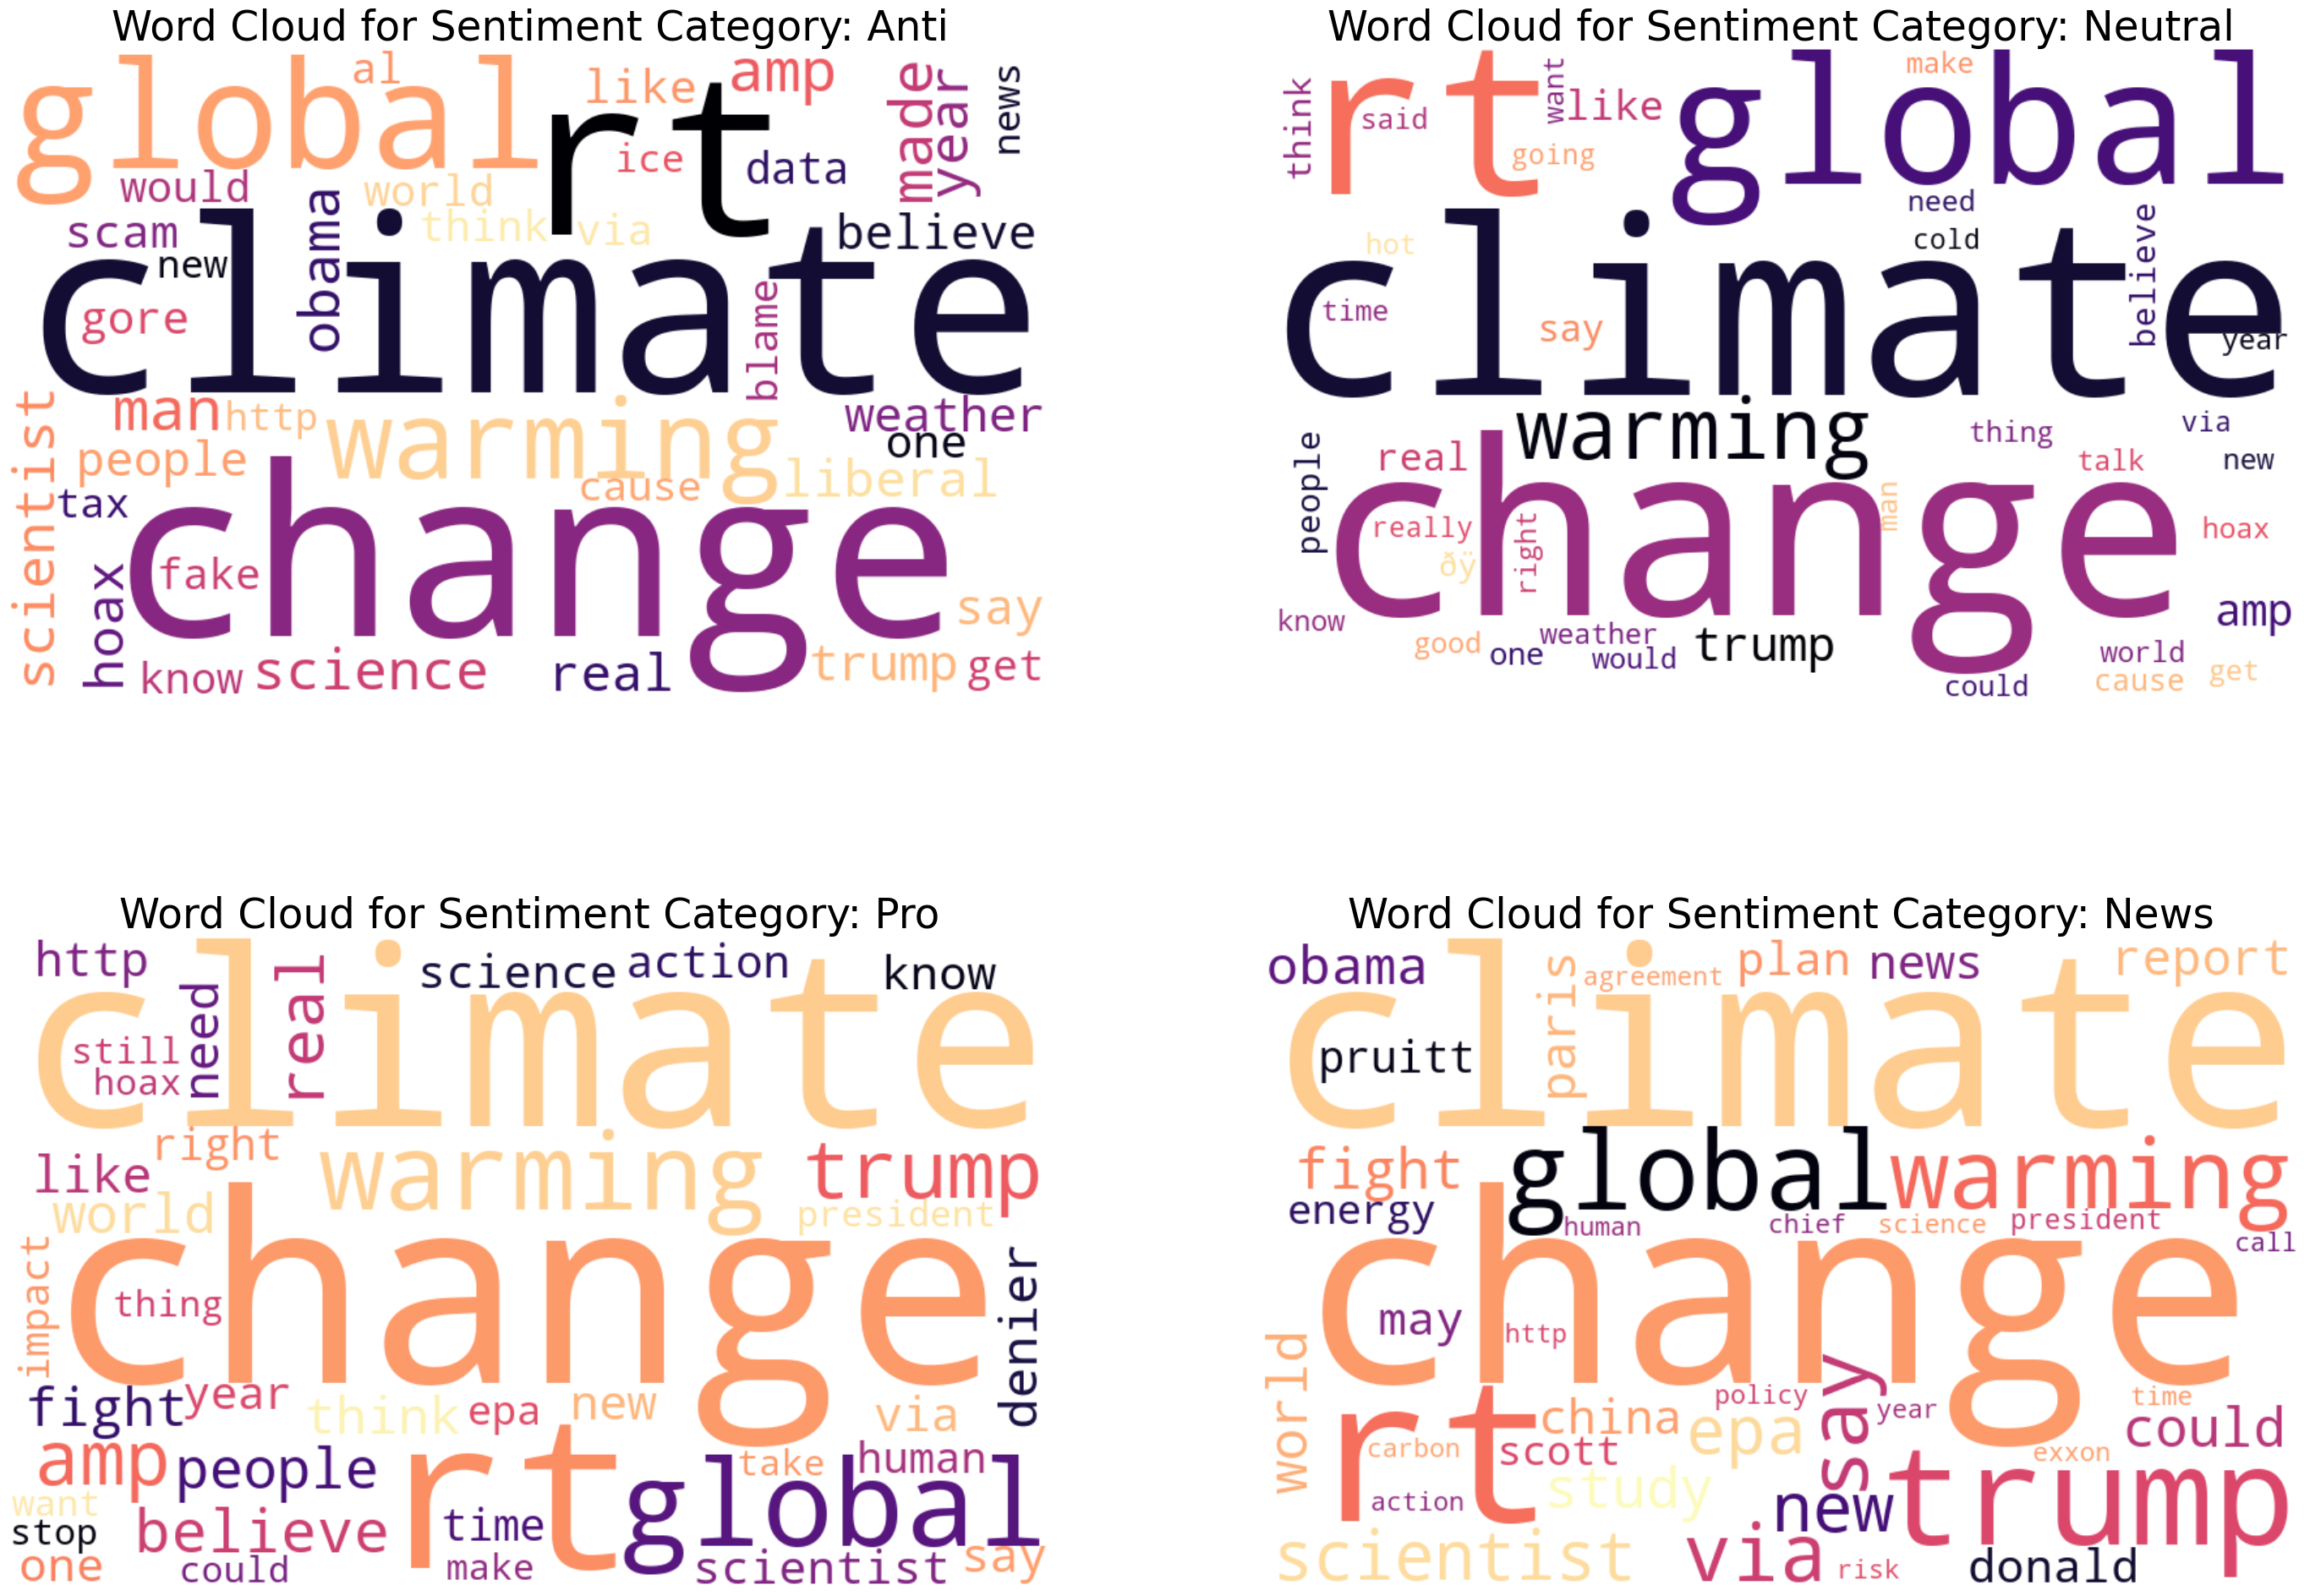

In [24]:
# Define category labels
category_labels = {-1: 'Anti', 0: 'Neutral', 1: 'Pro', 2: 'News'}

# Create subplots for each sentiment category
f, axarr = plt.subplots(2, 2, figsize=(35, 25))

# Group lemmatized tweets by sentiment categories
grouped_tweets = tweets.groupby('sentiment')

# Create word cloud for each sentiment category
for (sentiment, group), ax in zip(grouped_tweets, axarr.flatten()):
    # Count word frequencies using CountVectorizer
    cv = CountVectorizer()
    vect = cv.fit_transform(group['lemmatized_tweet'])
    
    # Get feature names (words)
    feature_names = cv.get_feature_names_out()

    # Convert sparse matrix to array and sum frequencies
    word_freq = dict(zip(feature_names, vect.toarray().sum(axis=0)))
    # Keep only the 40 most frequent words
    word_most_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:40])

    # Create word cloud
    wordcloud = WordCloud(width=800, height=500, background_color='white', colormap="magma", random_state=my_seed).generate_from_frequencies(word_most_freq)
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for Sentiment Category: {category_labels[sentiment]}', fontsize=35)
    ax.axis('off')

# Remove the ticks on the x and y axes
for ax in f.axes:
    ax.axis('off')

plt.show()

#### **Comments**:

The top 5 buzzwords accross all classes are **climate change**, **global warming** and **rt** (retweet). The frequency of rt means that a lot of the same information and/or opinions are being shared and viewed by large audiences. This is true for all 4 classes.

* The **Anti** sentiment word cloud prominently features words like **hoax**, **fake**, **tax**, **scam** and **blame**, suggesting a strong tendency towards conspiracy theories and skepticism about climate change. The presence of **global**, **warming**, and **climate change** indicates the subject matter. The term **Trump** appears here as well, potentially indicating that tweets in this category might frequently mention or be associated with statements by Donald Trump, who has publicly expressed skepticism about climate change. The term **liberal** might indicate a partisan framing of the climate change debate by those who are against it.

* The **Neutral** category contains a mix of terms, with **global**, **climate**, and **warming** still quite prominent, suggesting the central topic is well acknowledged. The appearance of neutral terms like **think**, **say**, and **year** indicates discussions that may be reporting on climate change or debating it without a clear advocacy or denial stance.

* In the **Pro** category, we see terms such as **action**, **science**, and **real**, which suggest a supportive stance on climate change recognition and action. The presence of **fight**, **believe**, and **impact** also highlights a sense of urgency and advocacy for addressing the issue.

* The **News** word cloud features names like **Obama**, **Trump**, and **Pruitt**, along with **Paris**, referring to the Paris Agreement. This indicates a focus on individuals and agreements central to climate policy and news reporting. Terms like **report**, **news**, **study**, and **scientist** suggest factual reporting and dissemination of information.


#### &bull; Embedding using `DistilBertModel` and its tokenizer

As said above, the `DistilBertTokenizerFast` considers the context of words and captures their semantic meaning. Therefore, it can be really nice to convert all our tweets into vectors thanks to this model. Let's see how we will proceed.

In [40]:
# Load pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load pre-trained DistilBERT model
model_BERT = DistilBertModel.from_pretrained('distilbert-base-uncased')


Processing texts in batches rather than one at a time significantly improves efficiency. The size of each batch will depend on the hardware's memory capacity; larger batches will decrease processing time but require more memory. Here, we decided to set `batch_size` at 32.

In [41]:
# This function will handle the batching of texts to encode them using the DistilBERT tokenizer
def batch_encode(texts, batch_size=32):
    input_ids = []
    attention_masks = []
    
    # Encode texts in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Tokenize the texts
        encoded_dict = tokenizer.batch_encode_plus(
            batch,
            add_special_tokens=True,
            max_length=64,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Append the input_ids and attention_masks to the lists
        # input_ids is a tensor of token indices to be fed to a model
        input_ids.append(encoded_dict['input_ids'])
        # attention_masks is a tensor of input tokens (1s) and padding tokens (0s)
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Concatenate all batches together
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

After encoding, we pass the tokens through DistilBERT to obtain the embeddings. Here, we choosed to use a mean pooling on the output of the last hidden state.

In [42]:
def extract_embeddings(input_ids, attention_masks):
    # Forward pass, get model output
    with torch.no_grad():
        outputs = model_BERT(input_ids, attention_mask=attention_masks)
    
    # Extract the last hidden states
    last_hidden_states = outputs.last_hidden_state
    
    # Average the token embeddings to get a single vector for each text input
    embeddings = torch.mean(last_hidden_states, dim=1)
    return embeddings

Then we apply this embedding on our data. Firstly, we apply this embedding on 1000 messages to check this embedding. 

In [44]:
sample_text = tweets['clean_tweet'].tolist()[:1000]
input_ids, attention_masks = batch_encode(sample_text)
embeddings_bert = extract_embeddings(input_ids, attention_masks)

# Convert embeddings into a numpy array for sklearn compatibility
embeddings_np = embeddings_bert.numpy()
print("Shape of the embedding", embeddings_np.shape)

Shape of the embedding (1000, 768)


DistilBERT, like other Transformer models, runs much faster on GPUs. On a CPU, processing tens of thousands of sentences might take a substantial amount of time (potentially hours), while a GPU could handle the same task in a fraction of that time.

Indeed, for only 1000 messages, it tooks around $40$ seconds to execute the code, but our dataset contains more than 40000 messages. Therefore, we have to find another method to embed the tweets we want to fill into the Machine Learning models.


#### &bull; `Word2Vec` embedding

[Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) is a classic method for generating word embeddings that capture semantic meanings based on the context in which words appear. The Word2Vec algorithms include skip-gram and CBOW models (continuous bag-of-words), using either hierarchical softmax or negative sampling. For more information, you can check the documentation of Word2Vec on Gensim website at [https://radimrehurek.com/gensim/models/word2vec.html](https://radimrehurek.com/gensim/models/word2vec.html) or you can see this article from GeeksforGeeks [https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/](https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/). This last article was very helpful to understand Word2Vec!

In [37]:
# Train a Word2Vec model
model_wv = Word2Vec(sentences=tweets['lemmatized_tweet_tokens'], vector_size=100, window=5, min_count=2, workers=4, seed=my_seed)

# Save the model for later use
model_wv.save("twitter_word2vec.model")

In [38]:
# Function to get a sentence embedding by averaging word vectors
def get_sentence_embedding(tokens, model):
    # Get word vectors, ignoring words that aren't in the model's vocabulary
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    # Handle cases where the sentence may not have any words in the model's vocab
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        # Average the word vectors
        return np.mean(vectors, axis=0)

In [39]:
# Calculate embeddings for each sentence
embeddings = [get_sentence_embedding(sentence, model_wv) for sentence in tweets['lemmatized_tweet_tokens'] if isinstance(sentence, list)]
embeddings = np.array(embeddings)

print(embeddings)
print(embeddings.shape)

[[-0.53928798  0.12590134 -0.29930314 ... -0.64632547  0.13751857
   0.07313797]
 [-0.37287959 -0.35752198 -0.00144438 ... -0.70700556  0.15425749
   0.12512216]
 [-0.33945101  0.05921251  0.03751886 ... -0.59453458  0.05186263
   0.23076726]
 ...
 [-0.38545021 -0.00860361  0.05120025 ... -0.84267926  0.07882849
   0.07884303]
 [-0.44057044 -0.07839981 -0.2137982  ... -0.69920164 -0.06278871
  -0.01354606]
 [-0.44470891 -0.23500484  0.02547542 ... -0.79000658  0.06671786
   0.00576102]]
(41041, 100)


This NLP part was really interesting and it took me a lot of time but I have learned many thinks from exploring the [Regular expressions](https://en.wikipedia.org/wiki/Regular_expression) to discovering various models and techniques to capture semantic meanings of a word based on the context. I am really interested in Transformers and NLP so I spent some time to really understand the various techniques.

Now, that we have our embeddings, let's try to predict sentiment thanks to ML models!

## 3. Model Training and Evaluation

In this section, we train several machine learning models to predict sentiment based on tweet embeddings generated from Word2Vec. We compare their performance using accuracy, [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to select the most effective model. This approach helps ensure that our findings are robust and generalize well to unseen data.


We first randomly split the data into train (80%) and test (20%) sets. This is done using a dedicated scikit-learn function (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [40]:
# Assuming 'embeddings' is a list or array of embeddings and 'data['sentiment']' is the target
X_train, X_test, y_train, y_test = train_test_split(embeddings, tweets['sentiment'], test_size=0.2, random_state=my_seed)

print('Train set: data set size =', X_train.shape[0], 'and target set size =', y_train.shape[0])
print('Test set: data set size =', X_test.shape[0])

Train set: data set size = 32832 and target set size = 32832
Test set: data set size = 8209


In [41]:
min_value_train = np.min(X_train)
min_value_test = np.min(X_test)
max_value_train = np.max(X_train)
max_value_test = np.max(X_test)

print("Minimum and maximum value of X_train:", min_value_train, max_value_train)
print("Minimum and maximum value of X_test:", min_value_test, max_value_test)


Minimum and maximum value of X_train: -1.8295608758926392 2.055586814880371
Minimum and maximum value of X_test: -1.8496522903442383 1.9867759943008423


Usually we normalize or standartize the data however for embeddings generated by pre-trained models like Word2Vec, the embeddings often already incorporate a form of scaling or normalization during their training process. Further scaling or normalization might not be necessary and could potentially distort the embeddings.

## **Multiclass Logistic Regression**

We begin with the foundational approach of [Multinomial Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)—a versatile algorithm well-suited for multi-class classification problems. This model is an extension of logistic regression that can handle outcomes that are more than two classes, making it ideal for distinguishing between multiple sentiment categories. To refine our model and mitigate overfitting, we explore regularization techniques: L1 (Lasso) and L2 (Ridge) penalties, each with its unique way of constraining the feature space. Lasso regression can reduce the number of features by assigning zero weight to less important features, leading to a sparse model, while Ridge regression decreases the magnitude of the coefficients to values close to zero, thus maintaining all features but distributing their impact. To validate our model's robustness and ensure it generalizes well to unseen data, we'll incorporate [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)—a technique that assesses the model's performance on different subsets of the data. 

This section will delve into setting up the Multinomial Logistic Regression with and without penalties, tuning the regularization strength, and employing cross-validation to ascertain the reliability of our sentiment classification.

### No regularization (no penalty)

In [30]:
def clf_LogisticRegression(X_train, y_train, X_test, y_test, weights, penalty, solver, my_seed=my_seed):
    # Create a Logistic Regression model
    clf = LogisticRegression(C=10,
                             multi_class='multinomial',
                             penalty=penalty, 
                             solver=solver,
                             class_weight=weights, 
                             max_iter=10000, 
                             random_state=my_seed)
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Predict the target
    y_pred = clf.predict(X_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred

In [42]:
# We set class_weight as 'balanced' because it uses the values of y to automatically adjust weights inversely proportional to 
# class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
# We saw that the distribution of our dataset is very imbalanced, so we use this parameter to balance the classes.
print("Multinomial Logistic Regression model with class_weight='balanced' and no regularization and no Cross-Validation: \n")

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)

    accuracy_1, y_pred_1 = clf_LogisticRegression(X_train, y_train, X_test, y_test, 'balanced', None, 'lbfgs')
    print("Accuracy of the Logistic Regression model with class_weight='balanced' and solver='lbfgs':", accuracy_1)

    accuracy_2, y_pred_2 = clf_LogisticRegression(X_train, y_train, X_test, y_test, 'balanced', None, 'saga')
    print("Accuracy of the Logistic Regression model with class_weight='balanced' and solver='saga':", accuracy_2, '\n')



Multinomial Logistic Regression model with class_weight='balanced' and no regularization and no Cross-Validation: 



Accuracy of the Logistic Regression model with class_weight='balanced' and solver='lbfgs': 0.514069923254964
Accuracy of the Logistic Regression model with class_weight='balanced' and solver='saga': 0.516506273602144 



In [32]:
# We set a custom class_weight because we want to assign a higher weight to the minority class.
weights = {-1: 2.0, 0: 1.5, 1: 1.0, 2: 1.5}

In [43]:
print("Multinomial Logistic Regression model with custom class_weight and no regularization and no Cross-Validation: \n")

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    
    accuracy_custom_weights_1, y_pred_custom_weights_1 = clf_LogisticRegression(X_train, y_train, X_test, y_test, weights, None, 'lbfgs')
    print("Accuracy of the Logistic Regression model with custom class_weight and solver='lbfgs':", accuracy_custom_weights_1)

    accuracy_custom_weights2, y_pred_custom_weights2 = clf_LogisticRegression(X_train, y_train, X_test, y_test, weights, None, 'saga')
    print("Accuracy of the Logistic Regression model with custom class_weight and solver='saga':", accuracy_custom_weights2, '\n')


Multinomial Logistic Regression model with custom class_weight and no regularization and no Cross-Validation: 



Accuracy of the Logistic Regression model with custom class_weight and solver='lbfgs': 0.5999512729930564
Accuracy of the Logistic Regression model with custom class_weight and solver='saga': 0.5995858204409794 



We have a better accuracy when using our custom class weight. Therefore, we will use this class weight for the rest of the project.

### Lasso Regression (l1 penalty)

In [34]:
# Logistic Regression with penalty='l1' and solver='saga'
accuracy_l1, y_pred_l1 = clf_LogisticRegression(X_train, y_train, X_test, y_test, weights, 'l1', 'saga')
print('Multinomial Logistic Regression Accuracy with l1 penalty and solver=saga:', accuracy_l1)

Multinomial Logistic Regression Accuracy with l1 penalty and solver=saga: 0.6023876233402363


### Ridge Regression (l2 penalty)

In [45]:
# Logistic Regression with penalty='l2' and solver='saga', 'lbfgs'
accuracy_l2_lbfgs, y_pred_l2_lbfgs = clf_LogisticRegression(X_train, y_train, X_test, y_test, weights, 'l2', 'lbfgs')
print('Multinomial Logistic Regression Accuracy with l2 penalty and solver=lbfgs:', accuracy_l2_lbfgs, '\n')

accuracy_l2_saga, y_pred_l2_saga = clf_LogisticRegression(X_train, y_train, X_test, y_test, weights, 'l2', 'saga')
print('Multinomial Logistic Regression Accuracy with l2 penalty and solver=saga:', accuracy_l2_saga)

Multinomial Logistic Regression Accuracy with l2 penalty and solver=lbfgs: 0.6023876233402363 

Multinomial Logistic Regression Accuracy with l2 penalty and solver=saga: 0.6027530758923133


Overall, we notice that we have the best result for l2 regularization term with the solver `lbfgs`. Now, let's do a Multinomial Logistic Regression with Cross-Validation in order to find the best performance. But first, we will plot the learning curve to analyse why l2 regularization was the best.

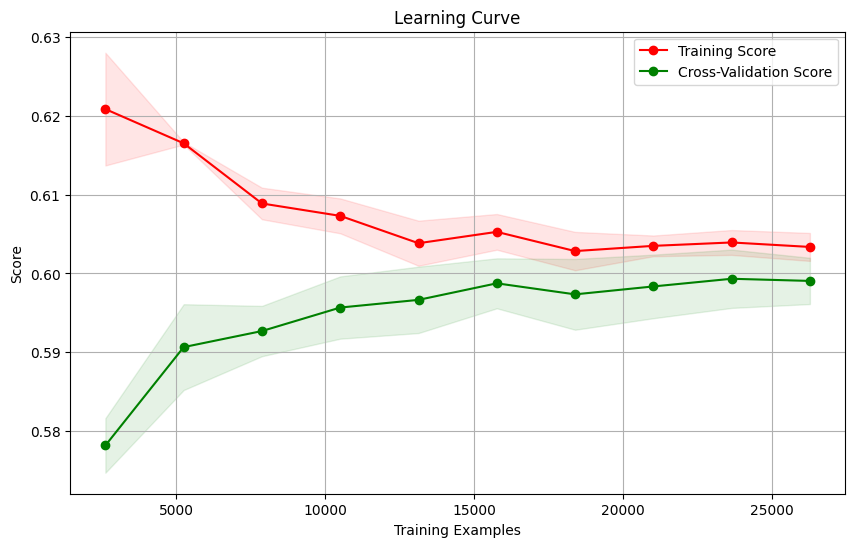

In [35]:
# Define your model
model = LogisticRegression(class_weight=weights, multi_class='multinomial', penalty=l2, solver='lbfgs', max_iter=10000)

# Define the learning curve parameters
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.legend(loc='best')
plt.show()


The training and cross-validation scores converge towards each other as the number of training examples increases. This is indicative of a good generalization of the model. If the training score was much higher than the cross-validation score, it would suggest overfitting.   

The plot suggests that l2 regularization contributes to the good performance of the logistic regression model by ensuring that it does not overfit and by allowing it to maintain good generalization to new, unseen data. This matches the observation that l2 regularization gave the best accuracy for your dataset, likely due to its effect in controlling the model complexity and improving generalization.

### Cross Validation

Now, let's compare with a logistic regression that includes a cross validation. We will do a cross validation into the model using the built in function https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html.

In [36]:
clf_cv_logReg = LogisticRegressionCV(cv=5, class_weight=weights, multi_class='multinomial', penalty='l2', solver='lbfgs', max_iter=10000)

start_time = time.time()
# fit data
clf_cv_logReg.fit(X_train, y_train)
run_time_lg = time.time() - start_time

# predict
y_pred_cv = clf_cv_logReg.predict(X_test)

# calculate accuracy
accuracy_cv = accuracy_score(y_test, y_pred_cv)

print(f"Multinomial Logistic Regression Accuracy with CV: {accuracy_cv}")

Multinomial Logistic Regression Accuracy with CV: 0.6019003532708004


We could also use `GridSearchCV` to find the best parameters. More specifically, we will try the best value for **C**, the inverse of regularization strength and we perform with **l2** penalty and **saga** solver as we saw that they gave us the best results.

In [37]:
# Define the model parameters
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]  # Creates 5 values for C, logarithmically spaced between 10^-2 and 10^2
}

log_reg = LogisticRegression(class_weight=weights, multi_class='multinomial', solver='saga', max_iter=10000)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, verbose=2, scoring='accuracy')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best logistic regression model
best_model = grid_search.best_estimator_

# Calculate accuracy and display the classification report
accuracy = best_model.score(X_test, y_test)
print(f"Best Model Accuracy: {accuracy}")
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ..............................................C=0.1; total time=   1.4s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ..............................................C=0.1; total time=   1.4s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ................................................C=1; total time=   6.4s
[CV] END ................................................C=1; total time=   6.3s
[CV] END ................................................C=1; total time=   5.8s
[CV] END ................................................C=1; total time=   6.4s
[CV] END ................................................C=1; total time=   6.3s
[CV] END ...............................................C=10; total time=  30.8s
[CV] END ........................................

We can analyse the results by looking at the confusion matrix, see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html. In the $i$ th line, we represent the predicted labels for the class labeled as $i-1$ (-1, 0, 1, 2) in the dataset.

Multinomial Logistic Regression Accuracy after CV: 0.6008039956145694


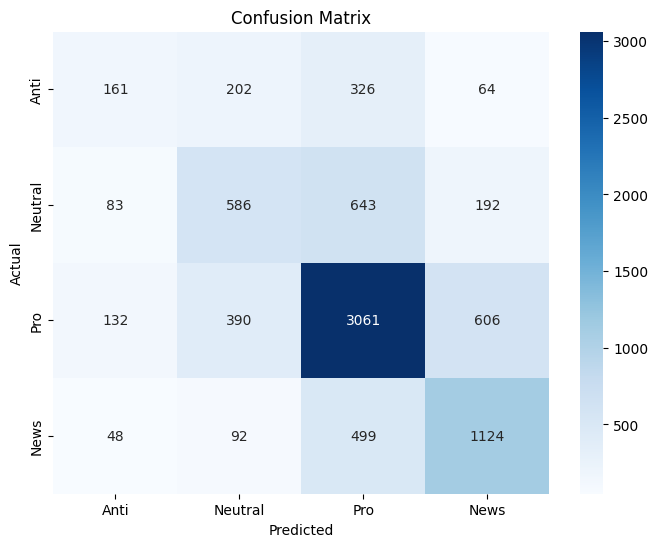

Classification report: 
               precision    recall  f1-score   support

        Anti       0.38      0.21      0.27       753
     Neutral       0.46      0.39      0.42      1504
         Pro       0.68      0.73      0.70      4189
        News       0.57      0.64      0.60      1763

    accuracy                           0.60      8209
   macro avg       0.52      0.49      0.50      8209
weighted avg       0.59      0.60      0.59      8209



In [38]:
# Accuracy
print('Multinomial Logistic Regression Accuracy after CV:', accuracy_cv)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cv, labels=[-1, 0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anti', 'Neutral', 'Pro', 'News'], yticklabels=['Anti', 'Neutral', 'Pro', 'News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
clf_report = classification_report(y_test, y_pred_cv, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)

The overall accuracy of the model is 0.60, which means it correctly predicts the sentiment 60% of the time across all classes. However, the macro average precision (0.52) and recall (0.49) are lower, indicating disparities in model performance across different classes. The weighted average for precision and recall is slightly higher due to the 'Pro' class having more weight because of its larger number of instances. So the classifier is most effective at identifying **Pro** tweets, with the highest recall and a good precision and **anti** tweets have the lowest recall, indicating many are misclassified as other categories, and a moderate precision.

Given that half of the messages in the dataset are **Pro**, followed by **News** (22%), **Neutral** (18%), and **Anti** (10%), the model demonstrates a strong bias towards the **Pro** category, achieving the highest recall in this category. This imbalance likely causes the model to be particularly tuned to the patterns and language prevalent in **Pro** messages, at the expense of the other categories, especially **Anti**, which not only has the smallest proportion but also shows poor recall and precision.

Therefore we have imposed a custom class weight in the model that doubles the weight for **Anti** and increase by 50% for **Neutral** and **News**. In this way, we obtain a better precision per category as before (with no class weight) and a better f1-score (better compared to the one using balanced class weight).

Let's check at some missclassified tweets.

In [39]:
index = 0
missclassifiedIndices = []
for label, predict in zip(y_test, y_pred_cv):
   if (label != predict):
      missclassifiedIndices.append(index)
   index +=1

category_labels = ['Anti', 'Neutral', 'Pro', 'News']

# print missclassified tweets
print('Missclassified tweets:')

# Sample of 5 missclassified tweets
sample_missclassified = rng.choice(missclassifiedIndices, 5, replace=False)

for index in sample_missclassified:
   print('Actual:', category_labels[y_test.iloc[index]+1], ', Predicted:', category_labels[y_pred_cv[index]+1],', tweet:', tweets['message'].iloc[index], '\n')



Missclassified tweets:
Actual: Pro , Predicted: News , tweet: RT @CarbonBrief: 196 countries to Trump: UN must tackle climate change | @KarlMathiesen @ClimateHome https://t.co/WJnW28bIf6 #COP22 https:/Ã¢â‚¬Â¦ 

Actual: Neutral , Predicted: Pro , tweet: Polar vortex shifting due to climate change, extending winter, study:
- 'idea...controversial'
https://t.co/2J4RlkU7cd 

Actual: Pro , Predicted: News , tweet: Trump falsely claims that nobody knows if global warming is real - Mashable https://t.co/kLn5W8Ob8v 

Actual: Neutral , Predicted: Anti , tweet: RT @scifri: Next on #SciFriLive: How to talk persuasively about climate change. https://t.co/mzU0LaEmck 

Actual: Neutral , Predicted: Pro , tweet: RT @MurffyJohn: @MBuhari d hypocrite how can u talk about climate change while ur country is full of I better pass my Neighbour #Generator?Ã¢â‚¬Â¦ 



In order to compare all the model at the end, we will store the results of the best Multinomial Logistic Regression in a dictionary.

In [40]:
best_results = {}
best_results['Logistic Regression'] = [accuracy_cv, y_pred_cv, run_time_lg]

## **SVM**

In the pursuit of refining our sentiment analysis model, we turn our attention to the robust and versatile method of Support Vector Machines (SVM). Known for its efficacy in high-dimensional spaces and adaptability to various types of data, SVM is a compelling choice for classifying textual data, such as tweets, into distinct sentiment categories. By constructing a hyperplane in a multidimensional space that distinctly classifies the data points, SVM helps in achieving both complexity and accuracy for our classification tasks. 

In this section, we'll delve into the application of SVM to our sentiment analysis model, discussing the setup, optimization, and evaluation of its performance against our dataset, providing insights into the intricacies of the approach and its effectiveness in discerning sentiment from text. The reference page on scikit-learn for SVM is https://scikit-learn.org/stable/modules/svm.html.

In [41]:
weights = {-1:2, 0:1.5, 1:1, 2:1.5}
svm_clf_basic = SVC(C=10, kernel='rbf', class_weight=weights, random_state=my_seed)
svm_clf_basic.fit(X_train, y_train)

# Predict the test set
y_pred_svm = svm_clf_basic.predict(X_test)

# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Accuracy:', accuracy_svm)

SVM Accuracy: 0.6198075283225728


We have a better accuracy using SVM than Multinomial Logistic Regression! Let's still improve the performances using Cross-Validation to find the best parameters.

NB: `X_train` is of shape (32832, 100) and knowing that the training of the model above took almost 3min, we will not be able to perform Cross-Validation on the whole training set. Instead, let's do it on half of it.

In [42]:
X_sample = X_train[:15000]
y_sample = y_train[:15000]

In [43]:
weights = {-1:2, 0:1.5, 1:1, 2:1.5}
svm_clf_basic = SVC(C=10, kernel='rbf', class_weight=weights)
svm_clf_basic.fit(X_sample, y_sample)

# Predict the test set
y_pred_svm = svm_clf_basic.predict(X_test)

# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Accuracy:', accuracy_svm)

SVM Accuracy: 0.610793032038007


The accuracy of the SVM model with only 15000 embeddings instead of 32832 is still close to the one we had with the whole training set. So let's do the `GridSearchCV` on the parameters **kernel** and **C**.

In [44]:
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 1000]  # Example values for regularization parameter
}

# Initialize the SVM classifier
svm = SVC(class_weight=weights)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_sample, y_sample)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 100, 'kernel': 'rbf'}
Best cross-validation score: 0.6069


Thanks to the cross-validation we know that the best parameters are $C=100$ and *kernel='rbf'*. However, it could be interesting to extend the $C$ values up to $10^4$ for example. I wanted to do such a `GridSearchCV` but even the above cross-validation took a lot of time so let's try with $C=10^3$ directly.

SVM accuracy after CV:  0.6311365574369594


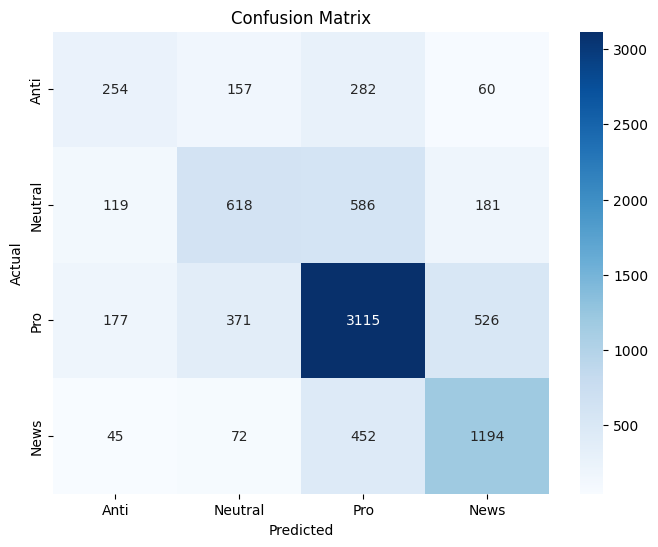

Classification Report:
               precision    recall  f1-score   support

          -1       0.43      0.34      0.38       753
           0       0.51      0.41      0.45      1504
           1       0.70      0.74      0.72      4189
           2       0.61      0.68      0.64      1763

    accuracy                           0.63      8209
   macro avg       0.56      0.54      0.55      8209
weighted avg       0.62      0.63      0.62      8209



In [45]:
best_model = SVC(C=1000, kernel='rbf', class_weight=weights)

start_time = time.time()
best_model.fit(X_train, y_train)
run_time_svm = time.time() - start_time

y_pred_svm_best = best_model.predict(X_test)

# calculate the accuracy
accuracy_svm_best = accuracy_score(y_test, y_pred_svm_best)
print("SVM accuracy after CV: ", accuracy_svm_best)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anti', 'Neutral', 'Pro', 'News'], yticklabels=['Anti', 'Neutral', 'Pro', 'News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svm_best))

The accuracy obtained with the Support Vector Machine model with $C=10^3$ is the best. It is even better than the one using Logistic Regression (0.63 vs 0.60). Indeed, when we look at the confusion matrix we observe that we still have the same imbalance as before but the number of misclassified tweets is lower than with logistic regression as the values in the diagonal of the confusion matrix are higher.

Moreover, concerning the precision, recall and f1-score, they are higher in each class. So globally, we can say that SVM has better performance than logistic regression.

We store the best performance of the best model in the `best_results` dictionary.

In [46]:
best_results['SVM'] = [accuracy_svm_best, y_pred_svm_best, run_time_svm]

## **Decision Trees and Random Forests**

## 1. Decision Trees

As we explore different avenues to optimize our sentiment analysis, we now shift our focus to Decision Trees—an intuitive and powerful classification method. Decision Trees are particularly appealing due to their simplicity in decision-making processes that mimic human decision logic, providing clear visualization of the path from features to conclusion. In the context of sentiment analysis, a Decision Tree model will enable us to classify tweets by splitting the data into branches based on feature values, leading to leaf nodes representing sentiment categories. 

This section will walk us through the implementation of a Decision Tree classifier (see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), detailing the decision criteria, tree depth, feature selection, and pruning strategies. We'll also assess how this model performs in accurately classifying sentiment from our dataset, ensuring our analysis is both comprehensive and discerning.

First of all, let's see what accuracy gives the DecisionTreeClassifier with default parameters, ie. **criterion='gini', splitter='best', max_depth=None, min_samples_split=2**, etc.


In [47]:
dt_default = DecisionTreeClassifier(class_weight=weights, random_state=my_seed) 
dt_default.fit(X_train,y_train)
y_pred = dt_default.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")


Decision Tree Accuracy: 0.5049336094530393


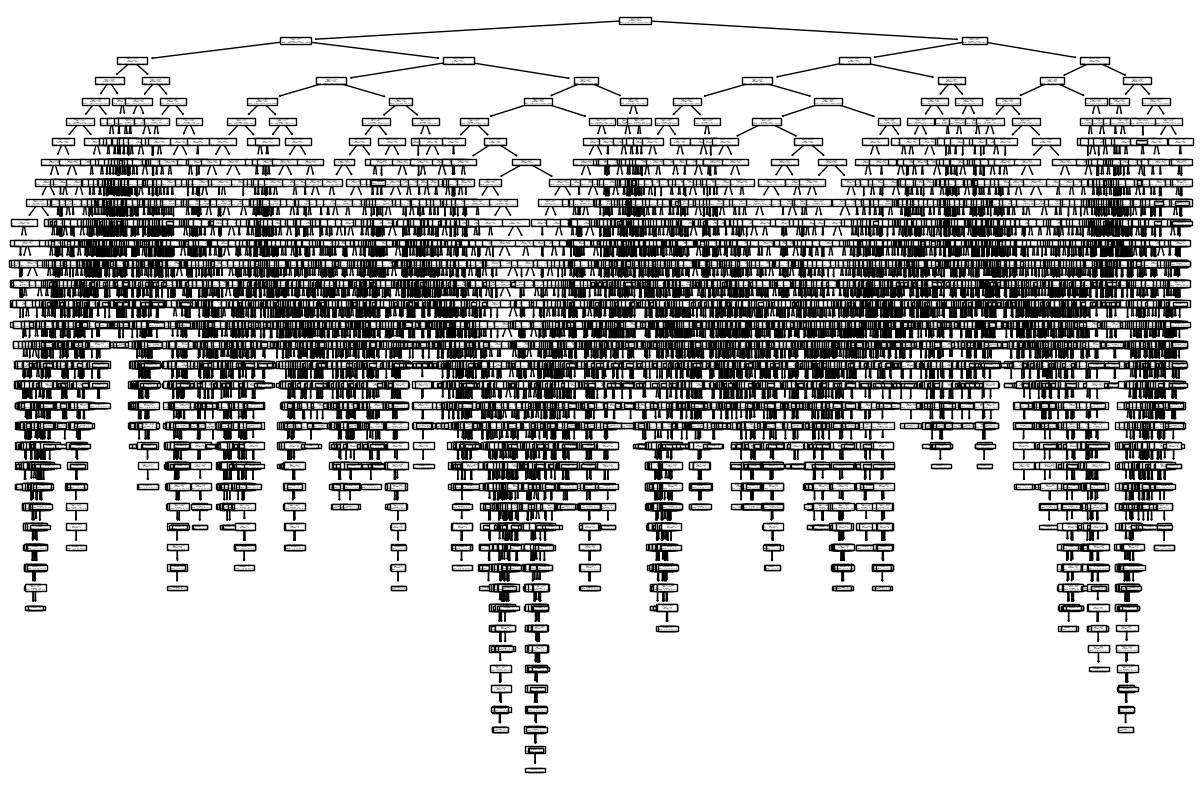

In [61]:
plt.figure(figsize=(15, 10))
plot_tree(dt_default)
plt.show()

What a beautiful tree we have! It looks like a weeping willow as there is no max_depth. But now, let's try with chosens **max_depth** and **min_samples_leaf**.

In [48]:
# choice of parameters 
chosen_max_depth = 10
chosen_min_samples_leaf = 2

# constructing + fitting the model and making the prediction
dt = DecisionTreeClassifier(max_depth=chosen_max_depth, min_samples_leaf=chosen_min_samples_leaf, class_weight=weights, random_state=my_seed) 
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")


Decision Tree Accuracy: 0.5459861128030211


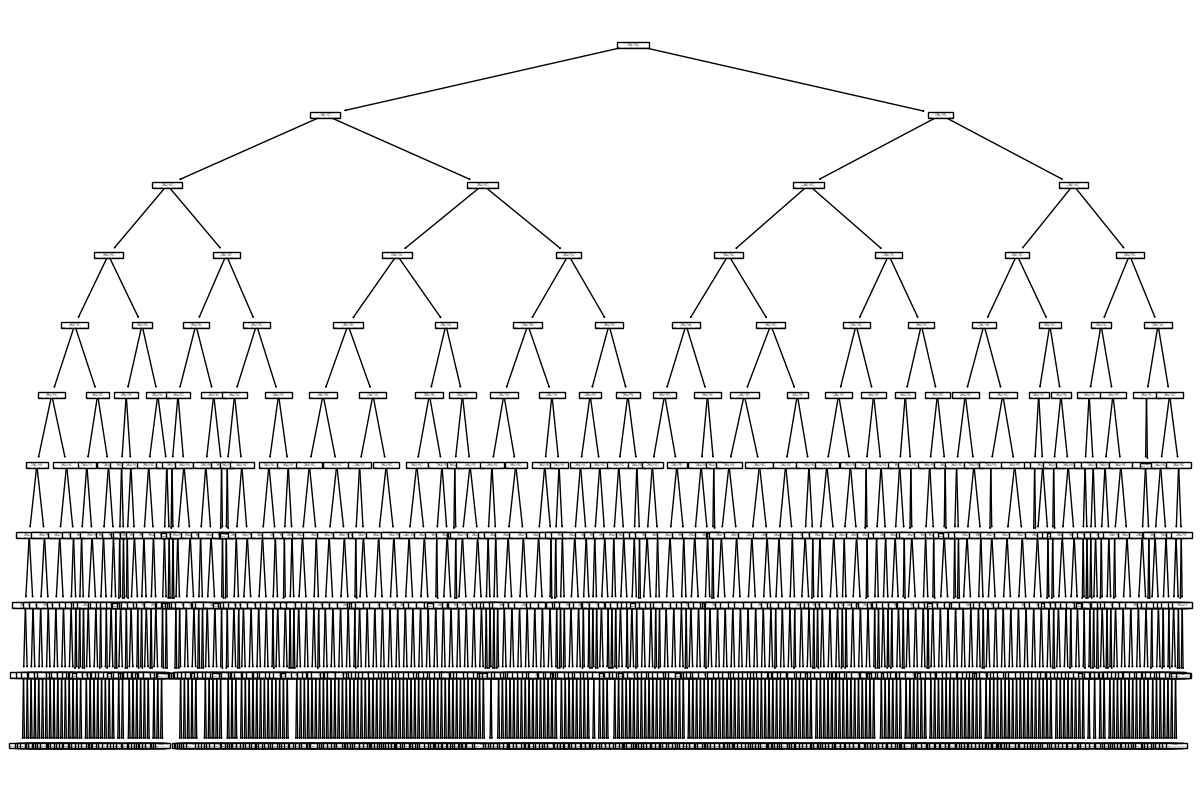

In [63]:
plt.figure(figsize=(15, 10))
plot_tree(dt)
plt.show()

The accuracy is better than the default Decision Tree!

**Cross-Validation to hypertune the parameters:**

We will try now to find the best hyperparameters for the model and then retrain the corresponding model and compute the associated outputs using Cross Validation.

We will hypertune ***max_depth***, the maximum depth of the tree and ***min_samples_leaf***, the minimum number of samples required to be at a leaf node for 4 different combinations of **criterion**, the function to measure the quality of a split. and **splitter**, the strategy used to choose the split at each node.

* Let's first begin with the default values for criterion and splitter: **gini** and **best** respectively, where 'best' strategy corresponds to choosing the best split.    

The quality of a candidate split of node $m$ is then computed using an impurity function $H()$ where the **Gini** measure is defined as:
$$ H(Q_m) = \sum_k p_{mk}(1 - p_{mk}) $$
where $Q_m$ is the data at node $m$ with $n_m$ samples and 
$$p_{mk} = \frac{1}{n_m} \sum_{y \in Q_m} I(y=k) $$ 
the proportion of class $k$ observations in node $m$.

In [49]:
# ----------- criterion 'gini' and splitter 'best' ----------------
param_grid = {
    'max_depth': np.arange(7,10,1),
    'min_samples_leaf': np.arange(1,4,1)
}

# Create a decision tree regressor
tree = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight=weights, random_state=my_seed)

# Create GridSearchCV object with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

a = grid_search.best_params_
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best score (negative mean squared error)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...max_depth=7, min_samples_leaf=1;, score=0.547 total time=   3.2s
[CV 2/5] END ...max_depth=7, min_samples_leaf=1;, score=0.544 total time=   3.2s
[CV 3/5] END ...max_depth=7, min_samples_leaf=1;, score=0.560 total time=   3.2s
[CV 4/5] END ...max_depth=7, min_samples_leaf=1;, score=0.560 total time=   3.3s
[CV 5/5] END ...max_depth=7, min_samples_leaf=1;, score=0.549 total time=   3.2s
[CV 1/5] END ...max_depth=7, min_samples_leaf=2;, score=0.547 total time=   3.2s
[CV 2/5] END ...max_depth=7, min_samples_leaf=2;, score=0.544 total time=   3.2s
[CV 3/5] END ...max_depth=7, min_samples_leaf=2;, score=0.560 total time=   3.2s
[CV 4/5] END ...max_depth=7, min_samples_leaf=2;, score=0.560 total time=   3.3s
[CV 5/5] END ...max_depth=7, min_samples_leaf=2;, score=0.549 total time=   3.2s
[CV 1/5] END ...max_depth=7, min_samples_leaf=3;, score=0.547 total time=   3.2s
[CV 2/5] END ...max_depth=7, min_samples_leaf=3;,

For criterion 'gini' and splitter 'best':
```  
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 2}  
Best Score: 0.5543070580475087
``` 

* Now, we are going to search for the maximum depth of the tree (**max_depth**) and the minimum number of samples required to be at a leaf node (**min_samples_leaf**) for criterion **gini** again but this time with a **random** splitter, which is the strategy of choosing the best random split.

In [50]:
# ----------- criterion 'gini' and splitter 'random' ----------------
param_grid = {
    'max_depth': np.arange(8,12,2),
    'min_samples_leaf': np.arange(2,7,2)
}

# Create a decision tree regressor
tree = DecisionTreeClassifier(criterion='gini', splitter='random', class_weight=weights, random_state=my_seed)

# Create GridSearchCV object with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

a = grid_search.best_params_
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best score (negative mean squared error)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=8, min_sam

With criterion '**gini**' and splitter '**random**':  
```
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 2}  
Best Score: 0.5508955395498988
```

* In the following, we will try another criterion with is **entropy**.

The entropy measure of impuritty is defined as:
$$H(Q_m) = - \sum_k p_{mk} log(p_{mk})$$
with the same notation as above.

Here, we will use the splitter strategy '**best**'.

In [51]:
# ----------- criterion 'entropy' and splitter 'best' ----------------
param_grid = {
    'max_depth': np.arange(8,12,2),
    'min_samples_leaf': np.arange(2,7,2)
}

# Create a decision tree regressor
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', class_weight=weights, random_state=my_seed)

# Create GridSearchCV object with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

a = grid_search.best_params_
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best score (negative mean squared error)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   5.4s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   5.3s
[CV] END ....................max_depth=8, min_samples_leaf=6; total time=   5.3s
[CV] END ....................max_depth=8, min_sam

With criterion '**entropy**' and splitter '**best**':  
```
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 2}  
Best Score: 0.5498293626171823
```

* Finally, we seach the best parameters with the criterion '**entropy**' and the splitter '**random**'.

In [52]:
# ----------- criterion 'entropy' and splitter 'random' ----------------
param_grid = {
    'max_depth': np.arange(8,12,2),
    'min_samples_leaf': np.arange(2,7,2)
}

# Create a decision tree regressor
tree = DecisionTreeClassifier(criterion='entropy', splitter='random', class_weight=weights, random_state=my_seed)

# Create GridSearchCV object with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

a = grid_search.best_params_
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best score (negative mean squared error)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=8, min_sam

With criterion '**entropy**' and splitter '**random**':  
```
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 4}  
Best Score: 0.5465095579152002
```

Over all the combination, we can conclude that the best parameters are:
* **criterion** = 'gini'
* **splitter** = 'best'
* **max_depth** = 8
* **min_samples_leaf** = 2

with a best score of **0.5543**.

However, manually, I have found an accuracy of **0.5669** with ```'max_depth' = 9``` and ```'min_samples_leaf' = 1```, which is better than the one found by cross-validation. Indeed, the values found by cross-validation can vary if a different test/train split is performed. Cross-validation is a technique that helps to assess the model's performance by splitting the data into multiple subsets and evaluating the model on each subset. Each subset serves as both a training and testing set. Therefore, the performance metrics obtained from cross-validation can vary depending on the specific data points included in each subset.


Decision Tree Accuracy after CV: 0.5500060908758679
Classification report: 
               precision    recall  f1-score   support

        Anti       0.29      0.21      0.24       753
     Neutral       0.44      0.33      0.38      1504
         Pro       0.63      0.68      0.65      4189
        News       0.51      0.57      0.54      1763

    accuracy                           0.55      8209
   macro avg       0.46      0.45      0.45      8209
weighted avg       0.54      0.55      0.54      8209



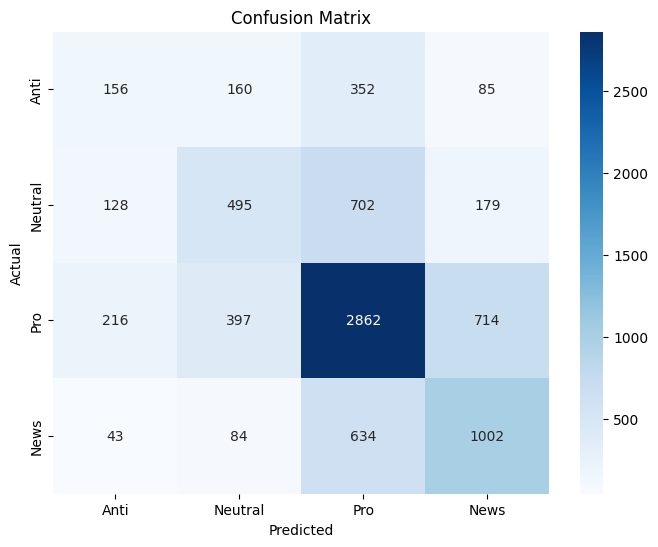

In [53]:
# training with best parameters
dt_best = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=9, min_samples_leaf=1, class_weight=weights, random_state=my_seed)

start_time = time.time()
dt_best.fit(X_train,y_train)
run_time_dt = time.time() - start_time

y_pred_dt_best = dt_best.predict(X_test)

# calculating the accuracy
accuracy_dt_best = accuracy_score(y_test, y_pred_dt_best)
print(f"Decision Tree Accuracy after CV: {accuracy_dt_best}")

# Confusion matrix 
cm = confusion_matrix(y_test, y_pred_dt_best, labels=[-1, 0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anti', 'Neutral', 'Pro', 'News'], yticklabels=['Anti', 'Neutral', 'Pro', 'News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Classification report
clf_report = classification_report(y_test, y_pred_dt_best, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)

In [54]:
best_results['Decision Tree'] = [accuracy_dt_best, y_pred_dt_best, run_time_dt ]

## 2. Random Forest

As we continue to refine our approach to sentiment analysis, we now turn to the robust methodology of Random Forest classification. You can find the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. This ensemble learning technique combines multiple decision trees to improve predictive accuracy and control over-fitting. By harnessing the collective power of numerous decision trees, a Random Forest classifier can effectively handle the complex nuances of language present in sentiment analysis. 

In this section, we'll explore how this method can enhance our model's ability to discern various sentiments expressed in tweets. We will cover the setup, the intricacies of parameter tuning, and the evaluation of a Random Forest classifier applied to our dataset, ultimately aiming for a model that is both accurate and generalizable.

Let's see first the accuracy given by the Random Forest classifier with the default parameters:
- ***n_estimators = 100***: The number of trees in the forest.
- ***max_depth = None***: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- ***min_samples_split = 2***: The minimum number of samples required to split an internal node.
- ***min_samples_leaf = 1***: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.   
etc...

In [55]:
# Function to create a Random Forest model
def clf_rf(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None, min_samples_leaf=1, my_seed=my_seed):
    # Create a Random Forest model
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, class_weight=weights, random_state=my_seed)
    
    start_time = time.time()
    # Fit the model
    rf.fit(X_train, y_train)
    run_time = time.time() - start_time
    
    # Predict the target
    y_pred = rf.predict(X_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred, run_time

In [56]:
accuracy_rf, y_pred_rf, _ = clf_rf(X_train, y_train, X_test, y_test)

# calculating the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Random Forest Accuracy: 0.6395419661347301


We notice that the default Random Forest accuracy gives the best accuracy amongst the previous model! Let's still try to improve its performance by searching for the best parameters using Cross-Validation.

In [57]:
rf_params = {'n_estimators':np.arange(100,151,25),
             'max_depth':np.arange(8,13,2),
             'min_samples_leaf':np.arange(1,5,2)}

# create a random forest classifier
rf = RandomForestClassifier(class_weight=weights, random_state=my_seed)

print('Grid search to find optimal parameters')

gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=2)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_ 
print('- Best number of trees = ',b['n_estimators'])
print('- Best maximal depth =', b['max_depth'])
print('- Best minimal number of samples in the leaves = ',b['min_samples_leaf'],'\n')

Grid search to find optimal parameters
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=100; total time=  23.1s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=100; total time=  22.8s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=100; total time=  22.9s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=100; total time=  23.2s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=100; total time=  23.0s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=  28.8s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=  28.8s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=  29.0s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=  28.6s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=125; total time=  28.5s
[CV] END ..max_depth=8, min_samples_leaf=1, n_estimators=150; total time=  34.2s
[CV] END 

After Cross-Validation, we have found that the best parameters are the following:
- Best number of trees =  125
- Best maximal depth = 12
- Best minimal number of samples in the leaves =  2

In [58]:
accuracy_cv_rf, y_pred_cv_rf, run_time_rf = clf_rf(X_train, y_train, X_test, y_test, 
                                                n_estimators=b['n_estimators'], 
                                                max_depth=b['max_depth'], 
                                                min_samples_leaf=b['min_samples_leaf']
                                              )

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")

Random Forest Accuracy: 0.5459861128030211


In [59]:
# fitting the model with best parameters
rf_best = RandomForestClassifier(n_estimators=b['n_estimators'], max_depth=b['max_depth'], min_samples_leaf=b['min_samples_leaf'], class_weight=weights, random_state=my_seed)
model = rf_best.fit(X_train,y_train)
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")

Random Forest Accuracy: 0.6302838348154465


However, we notice that the accuracy is lower than the one we had with default values. Indeed, we can notice that the best maximal depth is in fact the upper bound of our search space and the best minimal number of samples in the leaves is the lower bound. So we should ideally do a `GridSearchCV` with a wider search space. In fact, when I tested manually several values for *max_depth* and *min_samples_leaf*, I noticed that the best results were attained with the default values which are **max_depth=None** and **min_samples_leaf=1**. Let's still try to obtain the best number of trees with the default values for the other parameters.

In [ ]:
rf_params = {'n_estimators':np.arange(120,140,5)}

# create a random forest classifier
rf = RandomForestClassifier(class_weight=weights, random_state=my_seed)

rf_cv = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=2)
rf_cv.fit(X_train,y_train)
param = rf_cv.best_params_ 
print('- Best number of trees = ', param['n_estimators'])


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................................n_estimators=120; total time=  54.6s
[CV] END ...................................n_estimators=120; total time=  53.7s
[CV] END ...................................n_estimators=120; total time=  53.8s
[CV] END ...................................n_estimators=120; total time=  53.2s
[CV] END ...................................n_estimators=120; total time=  53.7s
[CV] END ...................................n_estimators=125; total time=  56.3s
[CV] END ...................................n_estimators=125; total time=  55.7s
[CV] END ...................................n_estimators=125; total time=  55.8s
[CV] END ...................................n_estimators=125; total time=  55.5s
[CV] END ...................................n_estimators=125; total time=  56.1s
[CV] END ...................................n_estimators=130; total time=  57.8s
[CV] END ...................................n_est

This cross-validation returned $135$ as the best number of trees. But I'm still not sure about that so let's try to find manually without cross-validation, how many trees we need to have the higher accuracy.

In [60]:
acc = []
for nb_tree in np.arange(120, 140):
    accuracy_rf, y_pred_rf, _ = clf_rf(X_train, y_train, X_test, y_test, nb_tree)
    acc.append([accuracy_rf, y_pred_rf])

In [ ]:
best_acc = 0
for i in range(len(acc)):
    if acc[i][0] > best_acc:
        best_acc = acc[i][0]
        best_pred = acc[i][1]
        index_best = i

In [ ]:
print('Best number of trees:', index_best+120, 'with accuracy:', best_acc)

Best number of trees: 130 with accuracy: 0.6403946887562432


Decision Tree Accuracy: 0.6386892435132172
Classification report: 
               precision    recall  f1-score   support

        Anti       0.53      0.15      0.23       753
     Neutral       0.54      0.32      0.41      1504
         Pro       0.64      0.86      0.74      4189
        News       0.70      0.59      0.64      1763

    accuracy                           0.64      8209
   macro avg       0.60      0.48      0.50      8209
weighted avg       0.63      0.64      0.61      8209



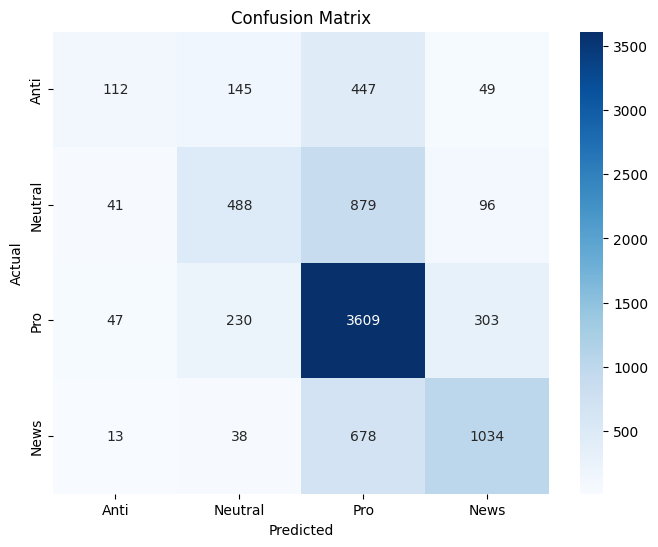

In [ ]:
# accuracy_rf_best, y_pred_rf_best, run_time_rf_best = clf_rf(X_train, y_train, X_test, y_test, index_best+120)
accuracy_rf_best, y_pred_rf_best, run_time_rf_best = clf_rf(X_train, y_train, X_test, y_test, 130)

# calculating the accuracy
print(f"Decision Tree Accuracy: {accuracy_rf_best}")

# Confusion matrix 
cm = confusion_matrix(y_test, y_pred_rf_best, labels=[-1, 0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anti', 'Neutral', 'Pro', 'News'], yticklabels=['Anti', 'Neutral', 'Pro', 'News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Classification report
clf_report = classification_report(y_test, y_pred_rf_best, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)

In [ ]:
best_results['Random Forest'] = [accuracy_rf_best, y_pred_rf_best, run_time_rf_best]

## **XGBoost**


Venturing further into the realm of advanced ensemble techniques, we arrive at a powerhouse of machine learning: [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html), short for Extreme Gradient Boosting. XGBoost employs a novel tree learning algorithm that successively builds models that correct the residuals of prior models, thereby improving accuracy iteratively. 

In this section, we will explore how XGBoost can be effectively applied to distinguish between the nuanced sentiments expressed in our dataset. We'll examine the setup of the XGBoost classifier, its parameter tuning for optimal performance, and the use of advanced techniques like regularization to enhance the model's ability to generalize from training to testing data. With its powerful handling of large datasets and its ability to manage sparse data typical of text, XGBoost stands as a compelling candidate for refining our sentiment analysis model.

In [ ]:
# XGBoost models expect the target variables (labels) to be numeric arrays with a base index of 0. 
# Therefore we have to do Label Encoding.
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Now, let's see what is the accuracy for XGBoost using the default values.

In [ ]:
# Use "hist" for constructing the trees, with early stopping enabled.
clf_xgb = xgb.XGBClassifier(random_state=my_seed)


# Fit the model, test sets are used for early stopping.
clf_xgb.fit(X_train, y_train_encoded, eval_set=[(X_test, y_test_encoded)])

[0]	validation_0-mlogloss:1.24258
[1]	validation_0-mlogloss:1.15584
[2]	validation_0-mlogloss:1.09772
[3]	validation_0-mlogloss:1.05666
[4]	validation_0-mlogloss:1.02812
[5]	validation_0-mlogloss:1.00724
[6]	validation_0-mlogloss:0.99132
[7]	validation_0-mlogloss:0.97917
[8]	validation_0-mlogloss:0.97015
[9]	validation_0-mlogloss:0.96166
[10]	validation_0-mlogloss:0.95596
[11]	validation_0-mlogloss:0.95061
[12]	validation_0-mlogloss:0.94671
[13]	validation_0-mlogloss:0.94284
[14]	validation_0-mlogloss:0.94024
[15]	validation_0-mlogloss:0.93776
[16]	validation_0-mlogloss:0.93555
[17]	validation_0-mlogloss:0.93353
[18]	validation_0-mlogloss:0.93153
[19]	validation_0-mlogloss:0.93020
[20]	validation_0-mlogloss:0.92850
[21]	validation_0-mlogloss:0.92715
[22]	validation_0-mlogloss:0.92572
[23]	validation_0-mlogloss:0.92431
[24]	validation_0-mlogloss:0.92277
[25]	validation_0-mlogloss:0.92202
[26]	validation_0-mlogloss:0.92143
[27]	validation_0-mlogloss:0.92049
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predict the test set
y_pred_xgb = clf_xgb.predict(X_test)

# Calculate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print('XGBoost Accuracy:', accuracy_xgb)

XGBoost Accuracy: 0.6363747106833962


Optimizing the accuracy of an XGBoost model involves selecting the right hyperparameters using `GridSearchCV` for example. We will hypertune the following parameters:

- **n_estimators**: The number of boosting rounds.
- **max_depth**: The maximum tree depth for base learners.
- **learning_rate (eta)**: The step size shrinkage used to prevent overfitting (Boosting learning rate).
- **subsample**: The fraction of samples used to fit the base learners, the subsample ratio of the training instance.

In [ ]:
# Define the model
xgb_model = xgb.XGBClassifier(random_state=my_seed)

# Parameters grid to search
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train_encoded)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best score
best_score = grid_search.best_score_
print("Best Score:", best_score)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250, 'subsample': 1.0}
Best Score: 0.6293556875099986


XGBoost Accuracy after CV: 0.6388110610305762


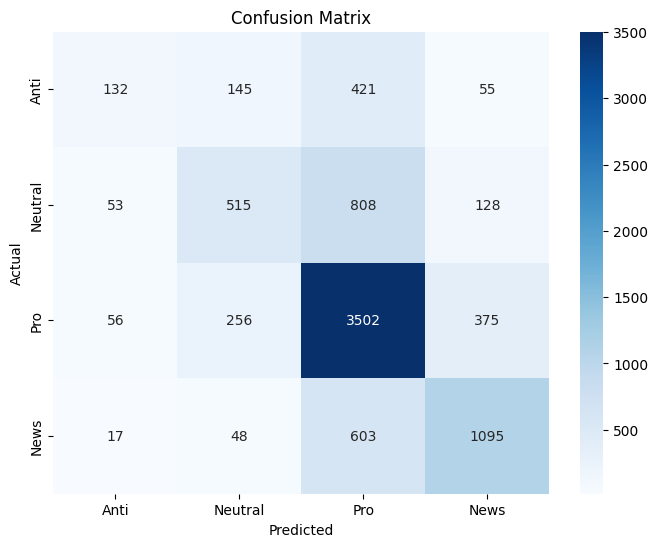

Classification report: 
               precision    recall  f1-score   support

        Anti       0.51      0.18      0.26       753
     Neutral       0.53      0.34      0.42      1504
         Pro       0.66      0.84      0.74      4189
        News       0.66      0.62      0.64      1763

    accuracy                           0.64      8209
   macro avg       0.59      0.49      0.51      8209
weighted avg       0.62      0.64      0.61      8209



In [ ]:
# Fit the best model
best_model = xgb.XGBClassifier(random_state=my_seed,**best_params)
best_model.fit(X_train, y_train_encoded)

# Predict the test set
y_pred_xgb_best = best_model.predict(X_test)

# Calculate the accuracy
accuracy_xgb_best = accuracy_score(y_test_encoded, y_pred_xgb_best)
print('XGBoost Accuracy after CV:', accuracy_xgb_best)

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_xgb_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anti', 'Neutral', 'Pro', 'News'], yticklabels=['Anti', 'Neutral', 'Pro', 'News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
clf_report = classification_report(y_test_encoded, y_pred_xgb_best, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)

In [ ]:
best_results['XGBoost'] = [accuracy_xgb_best, y_pred_xgb_best, run_time_xgb]

After finding the best estimator, we will plot a learning curve to visually assess how well the model is learning as more data is provided. This helps in understanding if the model is overfitting or underfitting:

- **Training Score**: Indicates the accuracy on the training set.
- **Cross-validation Score**: Indicates the accuracy on a validation set not seen by the model during training.
- **Shaded Areas**: Represent the variability (standard deviation) of the training and cross-validation scores, providing a visual cue about the stability of the model training.

The learning curve plot is crucial for verifying that the model generalizes well and does not just memorize the training data. A model is likely well-tuned if the training and validation scores converge to a similar value and the validation score improves with more training data.

In [ ]:
# Whole dataset
X = embeddings.copy()
y = tweets['sentiment'].copy()

y = label_encoder.fit_transform(y)

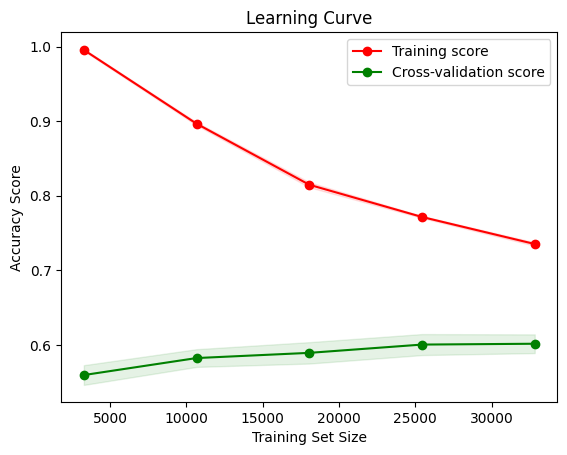

In [ ]:
# Plotting the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_estimator, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

# Mean and standard deviation of train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.show()

At the beginning, the training score is notably high, indicating that when the model is exposed to a small amount of data, it can almost perfectly predict or 'memorize' the outcomes. However, as more data is introduced, we observe a decline in the training accuracy. This decrease suggests that the model struggles to maintain its high performance when faced with the complexity and variability inherent in a larger dataset.

Conversely, the cross-validation score exhibits an upward trajectory as the size of the training set increases. This improvement reflects the model's growing capacity to generalize from the training data to previously unseen data.

The disparity between the training and cross-validation scores, particularly evident with smaller data sizes, signifies a potential overfitting scenario. Overfitting occurs when a model is too closely tailored to the training data, capturing noise and details that hinder its predictive performance on new data.

#### Early Stopping and regularization to reduce overfitting

We will use the `early_stopping_rounds` parameter in XGBoost to help reduce overfitting. This parameter allows to specify a number of rounds for which the model will continue training without seeing an improvement in the evaluation metric on a validation set. If there is no improvement beyond the specified number of rounds, the training process will stop early. This can prevent the model from continuing to learn the training data too closely, thus reducing overfitting.

To further reduce overfitting in XGBoost, we will do the following:

- ***tree_method***: This parameter specifies the method used to grow the trees. The '**hist**' method is a faster variant of the exact method that uses histograms to bucket the features and speed up training. This can help reduce overfitting by simplifying the tree growth process. 

- Reduce ***max_depth***: This parameter sets the maximum depth of a tree. Smaller trees are less complex and less likely to capture noise in the data.

- Increase ***subsample***: This is the fraction of the training data sampled for building trees. Values less than 1 can prevent overfitting by adding randomness to the training process.

- Increase ***colsample_bytree*** and ***colsample_bylevel***: These parameters control the fraction of features used per tree and per level, respectively. Using a subset of features prevents over-reliance on particular features and adds randomness.

- Increase ***min_child_weight***: This parameter controls the minimum sum of the instance weight (hessian) needed in a child. Increasing this value can lead to a more conservative model.

- ***eval_metric***: This parameter specifies the evaluation metric used to determine model performance. By choosing an appropriate metric, we can guide the model to optimize for the desired outcome and reduce overfitting.

- ***early_stopping_rounds***: This parameter can help prevent overfitting by stopping the training process if the evaluation metric does not improve for a specified number of rounds.

- Increase ***gamma***: This parameter encourages more conservative models by specifying the minimum loss reduction required to make a further partition on a leaf node of the tree.

- Adjust ***lambda*** and ***alpha***: These are L2 (lambda) and L1 (alpha) regularization terms on weights, respectively. They can be used to add regularization to the model, penalizing large weights.

XGBoost Training score: 0.6480263157894737
XGBoost Accuracy: 0.6133511999025459


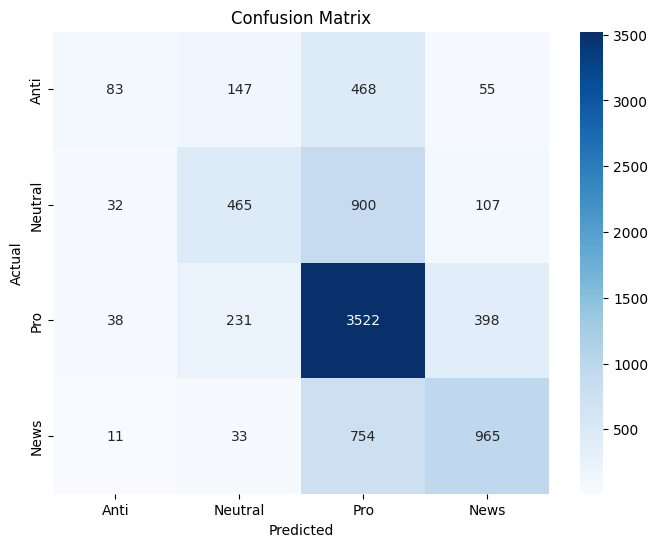

              precision    recall  f1-score   support

        Anti       0.51      0.11      0.18       753
     Neutral       0.53      0.31      0.39      1504
         Pro       0.62      0.84      0.72      4189
        News       0.63      0.55      0.59      1763

    accuracy                           0.61      8209
   macro avg       0.57      0.45      0.47      8209
weighted avg       0.60      0.61      0.58      8209



In [ ]:
# Define the model with parameters aimed at reducing overfitting
clf_xgb_opt = xgb.XGBClassifier(
    tree_method="hist",
    max_depth=3,               # Reduced max depth
    n_estimators=250,          # Number of trees
    learning_rate=0.1,         # Learning rate
    subsample=1,               # Subsample ratio of the training instances
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree
    min_child_weight=3,        # Higher than the default for additional conservatism
    eval_metric="mlogloss",    # Evaluation metric for multi-class classification
    early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
    gamma=1,                   # Minimum loss reduction required to make a further partition
    reg_lambda=1,              # L2 regularization term on weights
    reg_alpha=0.1,             # L1 regularization term on weights
    random_state=my_seed
)

start_time = time.time()
# Fit the model with early stopping
clf_xgb_opt.fit(
    X_train, y_train_encoded,
    eval_set=[(X_test, y_test_encoded)],
    verbose=False
)
run_time_xgb = time.time() - start_time

# Predictions and evaluation
y_train_pred = clf_xgb_opt.predict(X_train)
y_pred_xgb_opt = clf_xgb_opt.predict(X_test)

# Training score
training_score_xgb_opt = accuracy_score(y_train_encoded, y_train_pred)
print('XGBoost Training score:', training_score_xgb_opt)

# Accuracy
accuracy_xgb_opt = accuracy_score(y_test_encoded, y_pred_xgb_opt)
print('XGBoost Accuracy:', accuracy_xgb_opt)

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_xgb_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anti', 'Neutral', 'Pro', 'News'], yticklabels=['Anti', 'Neutral', 'Pro', 'News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test_encoded, y_pred_xgb_opt, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print(report)


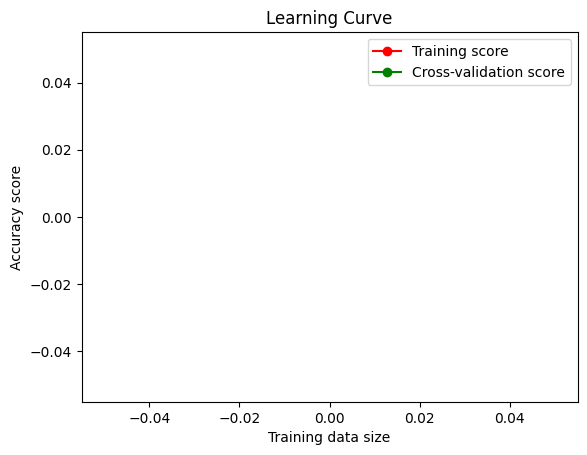

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    clf_xgb_opt, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=my_seed
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.plot(train_sizes, train_mean, label='Training score', color='r', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.15)

plt.plot(train_sizes, test_mean, label='Cross-validation score', color='g', marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.15)

plt.title('Learning Curve')
plt.xlabel('Training data size')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

We cannot use early stopping with cross-validation because early stopping requires a validation set to monitor the evaluation metric and stop training when the metric does not improve. Cross-validation splits the data into multiple training and validation sets, making it difficult to use early stopping effectively.

Some other machine learning algorithms, like those in *sklearn*, include early stopping as part of the estimator and may work with cross validation. However, using early stopping during cross validation may not be a perfect approach because it changes the model’s number of trees for each validation fold, leading to different model. A better approach is to retrain the model after cross validation using the best hyperparameters along with early stopping. Let's try to do that:

In [ ]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score

Average training score: 0.645 (+/- 0.001)
Average cross-validation score: 0.613 (+/- 0.003)


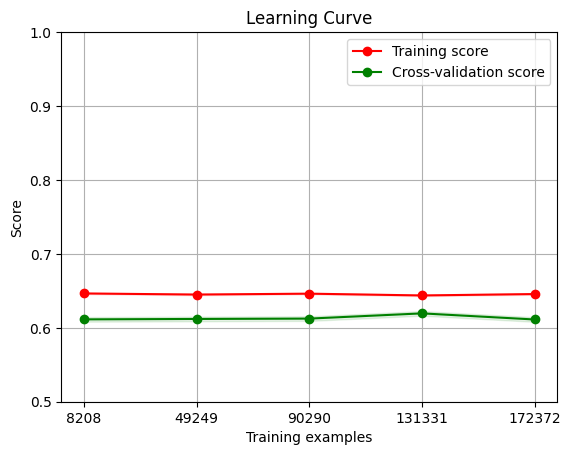

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

train_scores = []
test_scores = []

for train, test in cv.split(X, y):
    X_train_cv = X[train]
    X_test_cv = X[test]
    y_train_cv = y[train]
    y_test_cv = y[test]
    est, train_score, test_score = fit_and_score(
        clone(clf_xgb_opt), X_train_cv, X_test_cv, y_train_cv, y_test_cv
    )
    train_scores.append(train_score)
    test_scores.append(test_score)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores)
train_scores_std = np.std(train_scores)
test_scores_mean = np.mean(test_scores)
test_scores_std = np.std(test_scores)

# Print the average scores
print(f"Average training score: {train_scores_mean:.3f} (+/- {train_scores_std:.3f})")
print(f"Average cross-validation score: {test_scores_mean:.3f} (+/- {test_scores_std:.3f})")

# Plot learning curves
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the average training and test score lines at each training set size
plt.plot(train_scores, 'o-', color="r", label="Training score")
plt.plot(test_scores, 'o-', color="g", label="Cross-validation score")

# Plot the standard deviation as a shaded area around each line
plt.fill_between(range(5), train_scores - train_scores_std, train_scores + train_scores_std, alpha=0.1, color="r")
plt.fill_between(range(5), test_scores - test_scores_std, test_scores + test_scores_std, alpha=0.1, color="g")

plt.xticks(range(5), [f"{int((i+1 / 5) * len(X))}" for i in range(5)])
plt.legend()
plt.ylim(0.5, 1.0)
plt.show()

## 4. Comparison

In [ ]:
# We will transform best_results into a DataFrame
results_table = pd.DataFrame(best_results).T
results_table.columns = ['Accuracy', 'Predictions', 'Run Time']
results_table.index.name = 'Classifier'
results_table.reset_index(inplace=True)

In [ ]:
# Add more evaluation metrics
results_table['Precision'] = [precision_score(y_test, pred, average='weighted') for pred in results_table['Predictions']]
results_table['Recall'] = [recall_score(y_test, pred, average='weighted') for pred in results_table['Predictions']]
results_table['F1 score'] = [f1_score(y_test, pred, average='weighted') for pred in results_table['Predictions']]

# drop the column predictions
results_table.drop('Predictions', axis=1, inplace=True)

results_table


c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Classifier,Accuracy,Run Time,Precision,Recall,F1 score
0,Logistic Regression,0.600804,999.232586,0.586857,0.600804,0.590108
1,Decision Tree,0.55695,7.466264,0.551035,0.556950,0.552931
2,SVM,0.628457,1044.493085,0.618367,0.628457,0.621372
3,Random Forest,0.638689,122.632659,0.625412,0.638689,0.608259
4,XGBoost,0.557193,4.928036,0.266238,0.180777,0.173885


Based on the table, **Random Forest** seems to be the best performing model considering the trade-off between accuracy and run time. It has the highest accuracy and competitive precision and F1 scores, while its run time is relatively moderate. **SVM** also has good metrics but is less desirable due to its very long run time. **Logistic Regression** and **XGBoost**, despite their moderate accuracies, have issues either with run time or with precision and recall, making them less suitable. **Decision Tree** has the lowest scores across all performance metrics, indicating that it is the least suitable model of the five.

To sum up, the **Random Forest** model is the most suitable for sentiment analysis of tweets in this dataset. It achieves the highest accuracy and competitive precision and F1 scores, while maintaining a moderate run time. The model's performance is robust across different metrics, making it a reliable choice for classifying sentiments in tweets. The **Random Forest** model's ability to handle complex relationships in the data and avoid overfitting contributes to its effectiveness in capturing the nuances of language and sentiment expressed in tweets. By leveraging ensemble learning techniques and multiple decision trees, the **Random Forest** model excels in discerning the sentiment categories present in the dataset, providing a comprehensive and accurate classification of tweets.

## CONCLUSION

This project was very interesting because I discovered many things in Natural Language Processing. I've learned how to preprocess the tweets, how to tokenize them, how to embed them using *Word2Vec* and how to predict the sentiment using different models. I have also learned that some models are more suitable for some problems than others. Indeed, in this project, the **Random Forest** model was the best one for sentiment analysis. However, I wanted to use more complex models like *BERT* to get better results. I will try to do that in the future. I hope that you have learned as much as I did with this project.